# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [3]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [4]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [5]:
def norm_filter(adata, mito_genes, RB_genes_in_data
                , log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [6]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [39]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('../DEA/' + cell_type):
        os.makedirs('../DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)
    
    expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [41]:
def run_MAST_for_celltype_condition(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST_condition.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file )
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [9]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [10]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [11]:
adata_oligo = sc.read_h5ad(outdir+'adata_high_var_Oligo_diff_norm_clusters.h5ad')

# Subset Oligo Brainstem & Input original Adata

In [12]:
adata_oligo_BS = adata_oligo.copy()
adata_oligo_BS = adata_oligo_BS[adata_oligo_BS.obs['B_region'].isin(['BrainStem']),:]
adata_oligo_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4132, 13466)

In [13]:
adata_oligo_BS.obs.Condition.value_counts()

VE         2752
Control    1380
Name: Condition, dtype: int64

In [14]:
broad_clusters = adata_oligo_BS.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_oligo_BS.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 1380})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 2752})


In [15]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [16]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [17]:
adata_oligo_BS = adata[adata_oligo_BS.obs.index, :]
adata_oligo_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4132, 22292)

# Pre-processing

## QC

In [18]:
adata_oligo_BS, mito_genes, RB_genes_in_data = qc_metrics(adata_oligo_BS)
markers = []
if type(adata_oligo_BS.X)==np.ndarray:
    pass
else:
    print(type(adata_oligo_BS.X))
    #print(adata_norm.X.shape)
    adata_oligo_BS.X = adata_oligo_BS.X.toarray()
    #print(adata_norm.X.shape)
adata_oligo_BS.X = pd.DataFrame(data=adata_oligo_BS.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [19]:
adata_oligo_BS.shape

(4132, 22292)

## Normalization

In [20]:
markers = []
adata_oligo_BS, markers = norm_filter(adata_oligo_BS, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_oligo_BS.obs.head()

(4132, 22292)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4132, 13377)
(4132, 13199)
(4132, 13186)
True
Im here2


Trying to set attribute `.uns` of view, copying.


2000
2000


Sample ID  \
cell_barcodes                                                                          
126682808839406_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   

                                                  Condition   B_region  \
cell_barcodes                                                            
126682808839406_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   

                                                   n_genes_by_counts  \
cell_barcodes                                                          
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                   1065   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3               2291   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                    976   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3                881   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                   1009   

                                                   log1p_n_genes_by_counts  \
cell_barcodes                                                                
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                     6.971669   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 7.737180   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                     6.884487   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 6.782192   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                     6.917706   

                                                   total_counts  \
cell_barcodes                                                     
126682808839406_1822_996_VE_ES_BS_IGO_10875_7            1692.0   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3        4746.0   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7            1559.0   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3        1457.0   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7            1580.0   

                                                   log1p_total_counts  \
cell_barcodes                                                           
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                7.434258   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3            8.465268   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                7.352441   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3            7.284821   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                7.365813   

                                                   pct_counts_in_top_50_genes  \
cell_barcodes                                                                   
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                       22.044917   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   28.107880   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                       28.223220   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   28.826356   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                       24.683544   

                                                   pct_counts_in_top_100_genes  \
cell_barcodes                                                                    
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                        31.560284   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3                    34.091867   
160218196

## PCA

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4132, 13186)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


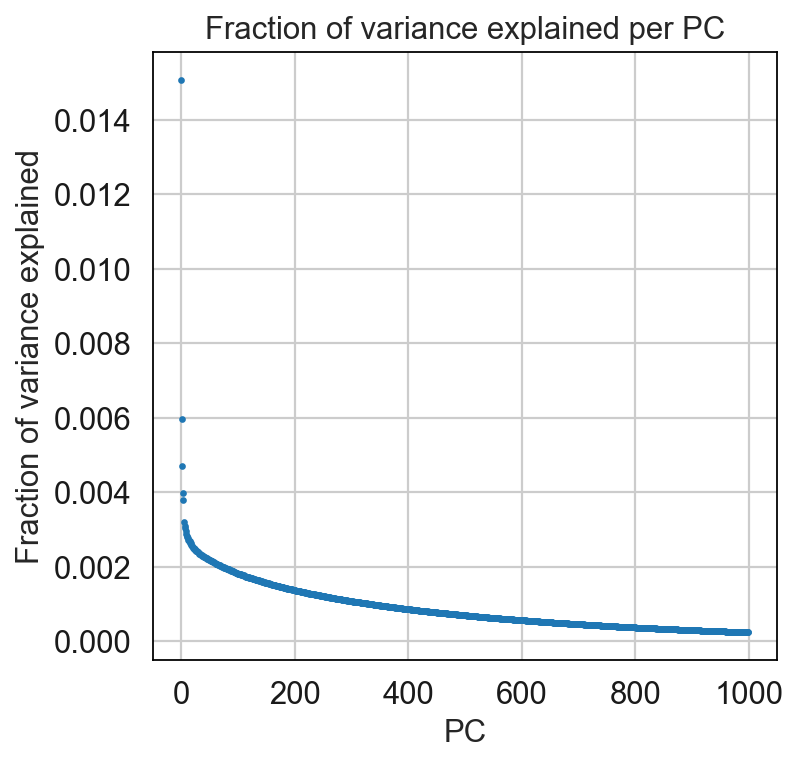

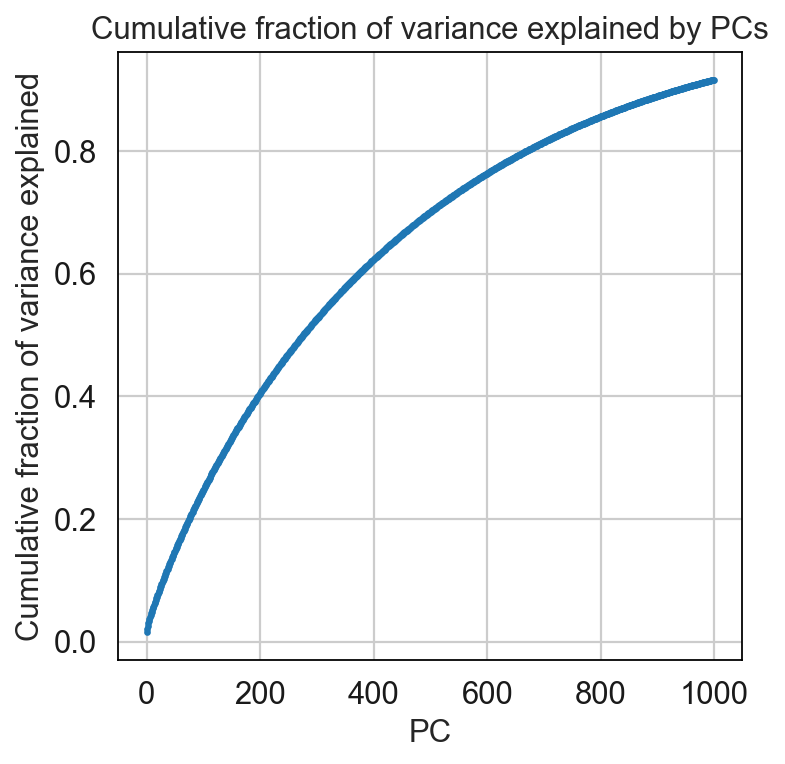

Knee point: 21
Explained variance: 0.08076464


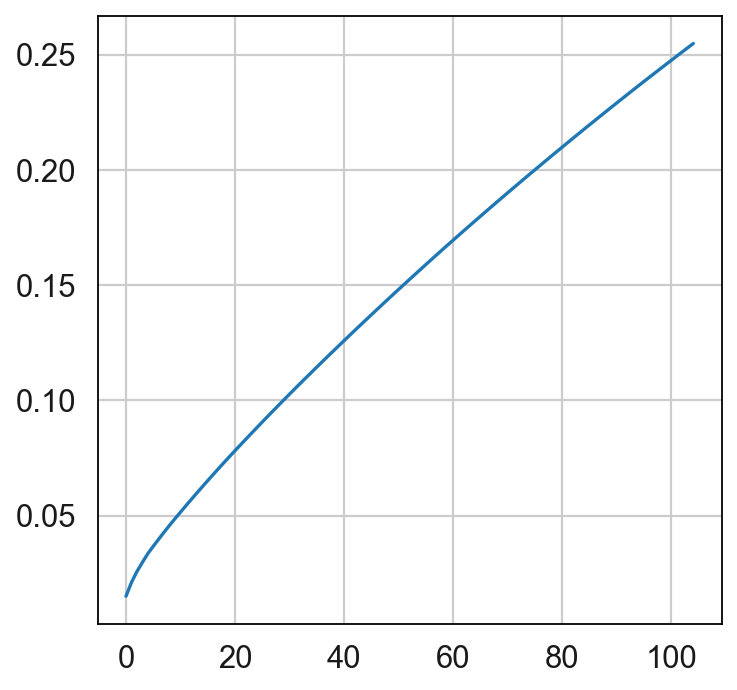

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


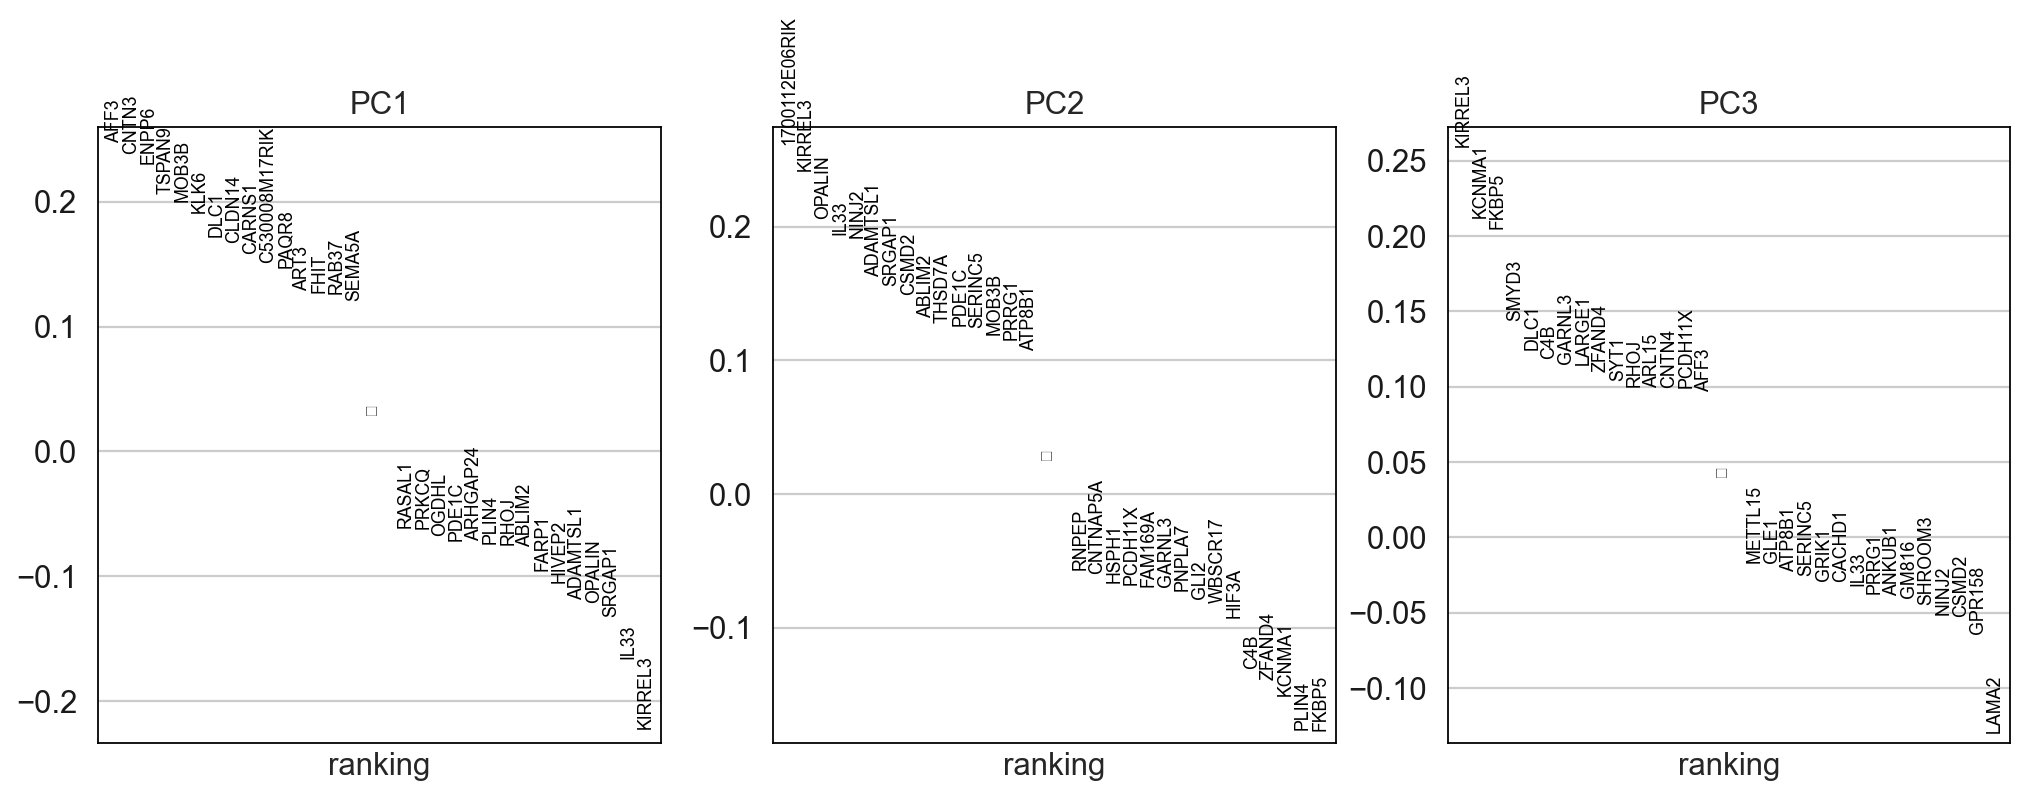

(4132, 13186)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
sc.set_figure_params(figsize=(5, 5))
adata_oligo_BS = run_pca_knee(adata_oligo_BS)#, 0.5)
adata_oligo_BS.obs['PC 1'] = adata_oligo_BS.obsm['X_pca'][:,0] # optional
adata_oligo_BS.obs['PC 2'] = adata_oligo_BS.obsm['X_pca'][:,1]
adata_oligo_BS.obs['PC 3'] = adata_oligo_BS.obsm['X_pca'][:,2]

print(adata_oligo_BS.shape)
adata_oligo_BS.X = pd.DataFrame(adata_oligo_BS.X).fillna(0).values
index_list = np.arange(adata_oligo_BS.shape[0])
np.random.shuffle(index_list)
adata_oligo_BS = adata_oligo_BS[index_list,:]

In [22]:
print(adata_oligo_BS.shape)
adata_oligo_BS.X = pd.DataFrame(adata_oligo_BS.X).fillna(0).values
index_list = np.arange(adata_oligo_BS.shape[0])
np.random.shuffle(index_list)
adata_oligo_BS = adata_oligo_BS[index_list,:]

(4132, 13186)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.30521607398986816 seconds
Jaccard graph constructed in 0.8764128684997559 seconds
Wrote graph to binary file in 0.18041110038757324 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.689485
After 3 runs, maximum modularity is Q = 0.690501
After 13 runs, maximum modularity is Q = 0.692482
Louvain completed 33 runs in 1.534339189529419 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.5477471351623535 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2758803367614746 seconds
Jaccard graph constructed in 0.9122848510742188 seconds
Wrote graph to binary file in 0.16833209991455078 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.622531
After 2 runs, maximum modularity is Q = 0.626015
After 3 runs, maximum modularity is Q = 0.629089
Louvain completed 23 runs in 1.3859121799468994 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.390780210494995 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3046400547027588 seconds
Jaccard graph constructed in 0.946246862411499 seconds
Wrote graph to binary file in 0.18134093284606934 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.600206
After 6 runs, maximum modularity is Q = 0.601353
After 9 runs, maximum modularity is Q = 0.603073
Louva

Text(0.5, 0, 'k')

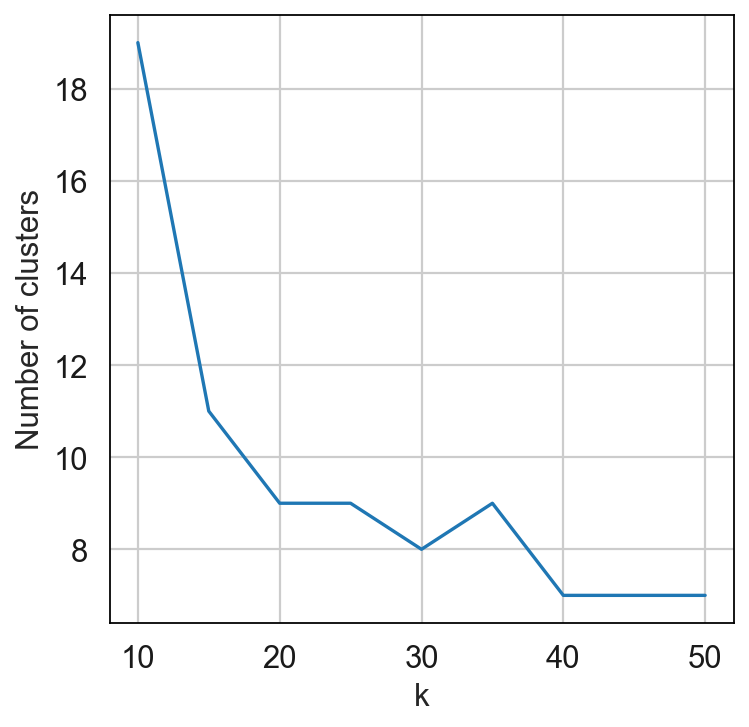

In [23]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_oligo_BS.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'+str(k)] = pd.Categorical(communities)
    adata_oligo_BS.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_oligo_BS.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [24]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'+str(k_list[run1])].values,
            adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

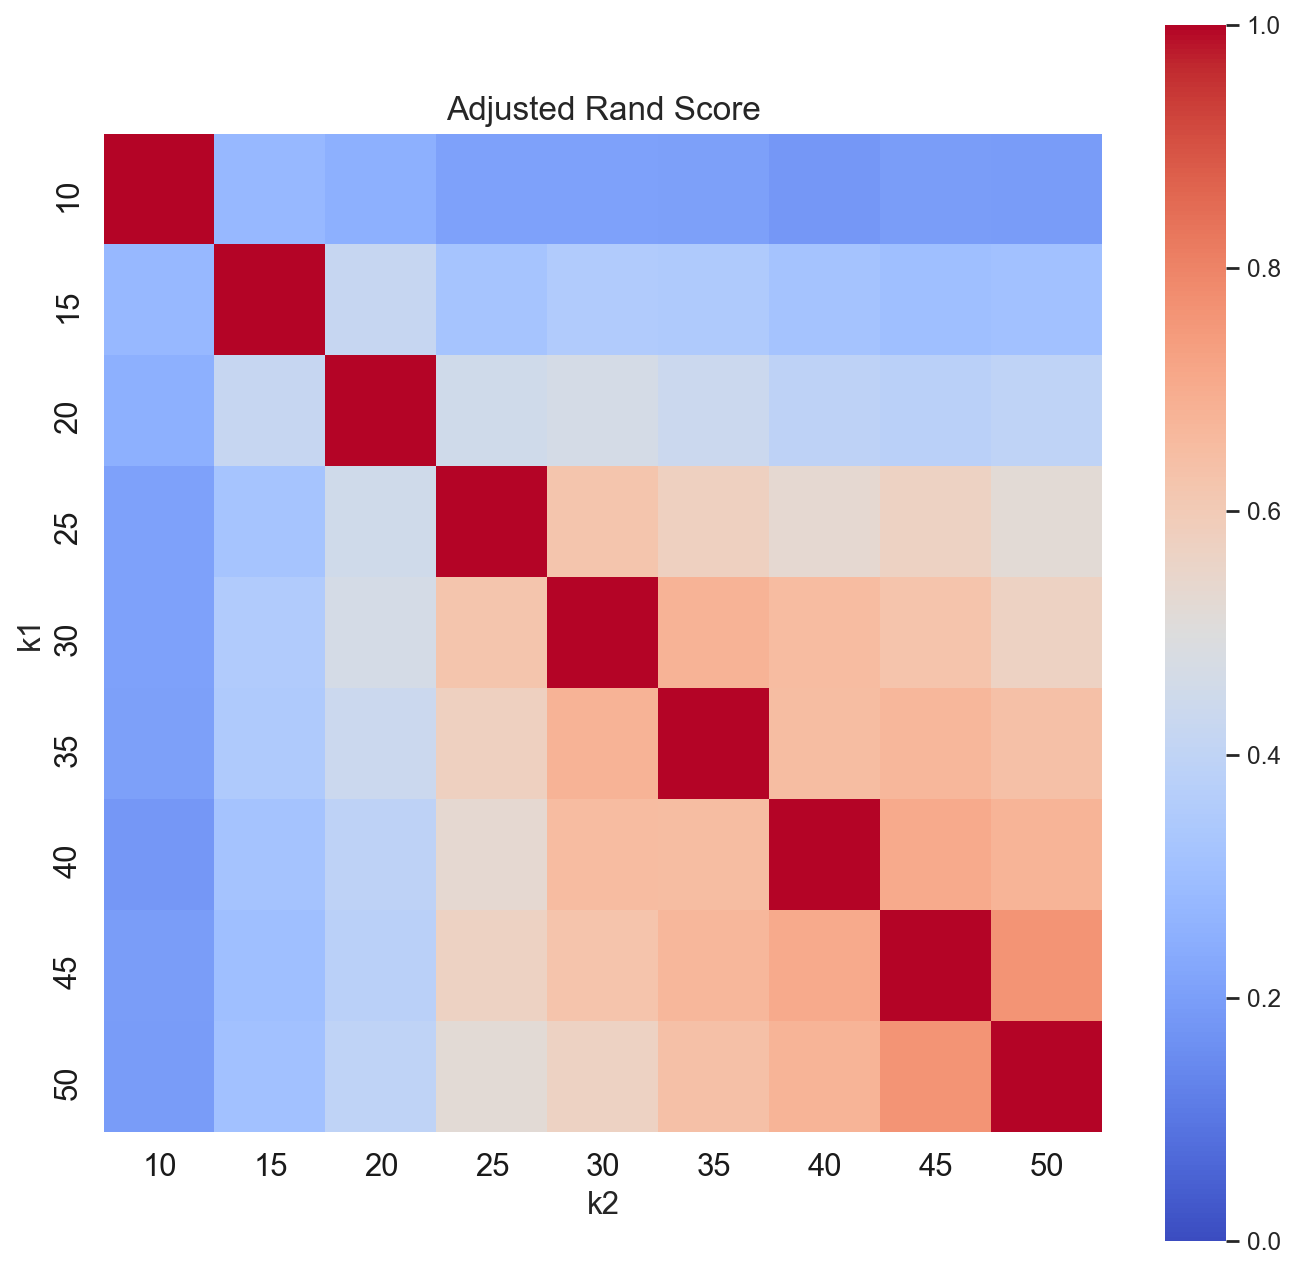

In [25]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [25]:
k = 45 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_oligo_BS.obsm['X_pca']),k=k) # run PhenoGraph
adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'] = pd.Categorical(communities)
adata_oligo_BS.uns['PhenoGraph_Q'] = Q
adata_oligo_BS.uns['PhenoGraph_k'] = k

Finding 45 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.28020691871643066 seconds
Jaccard graph constructed in 1.395716667175293 seconds
Wrote graph to binary file in 0.4810338020324707 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.534939
After 2 runs, maximum modularity is Q = 0.550246
After 5 runs, maximum modularity is Q = 0.553999
Louvain completed 25 runs in 2.6262450218200684 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 5.471414089202881 seconds


# Vizualization & Markers

## Vizualize Oligo BS sub-clusters

In [26]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_oligo_BS, method='umap', use_rep='X_pca')
sc.tl.umap(adata_oligo_BS, random_state=None)

... storing 'Condition' as categorical
... storing 'B_region' as categorical


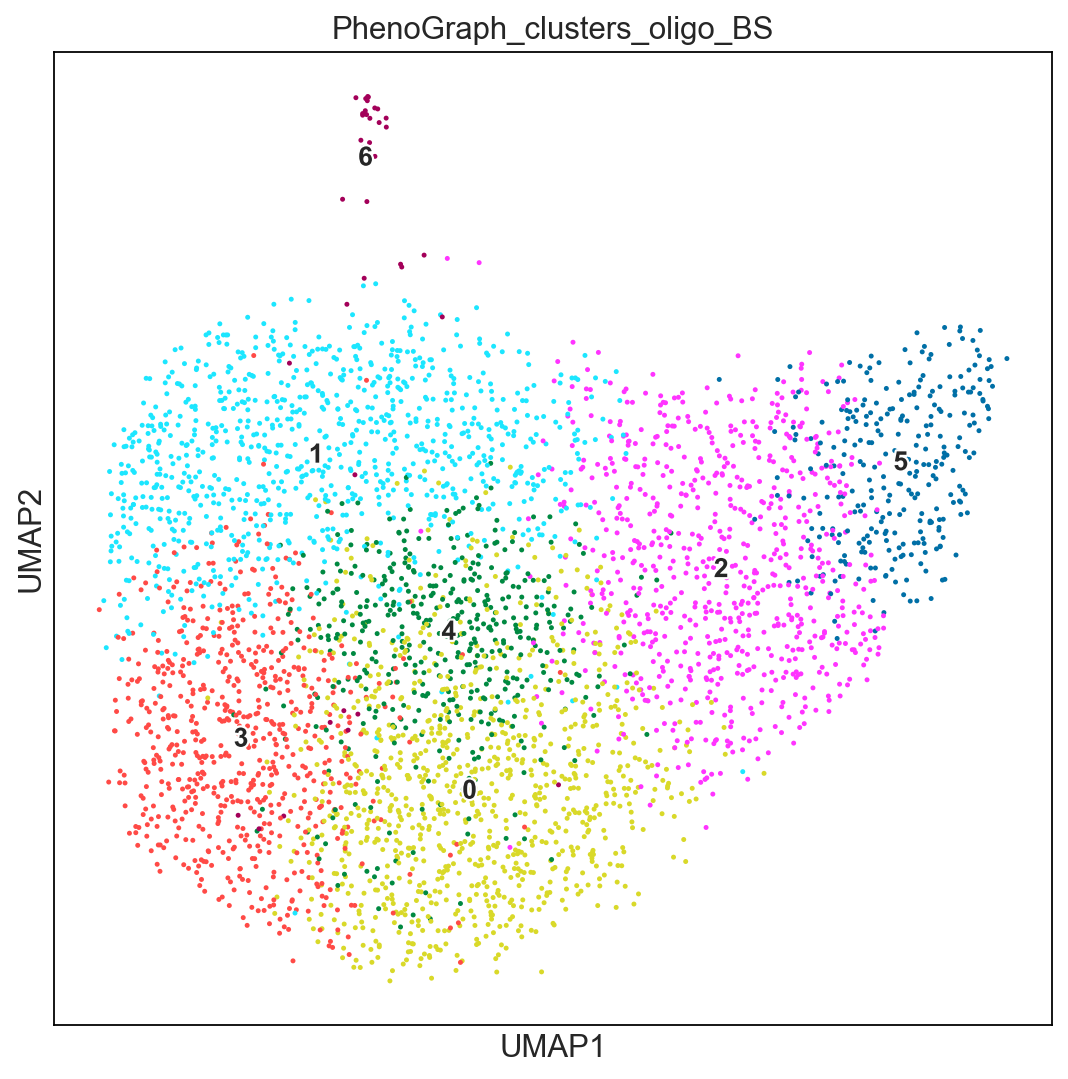

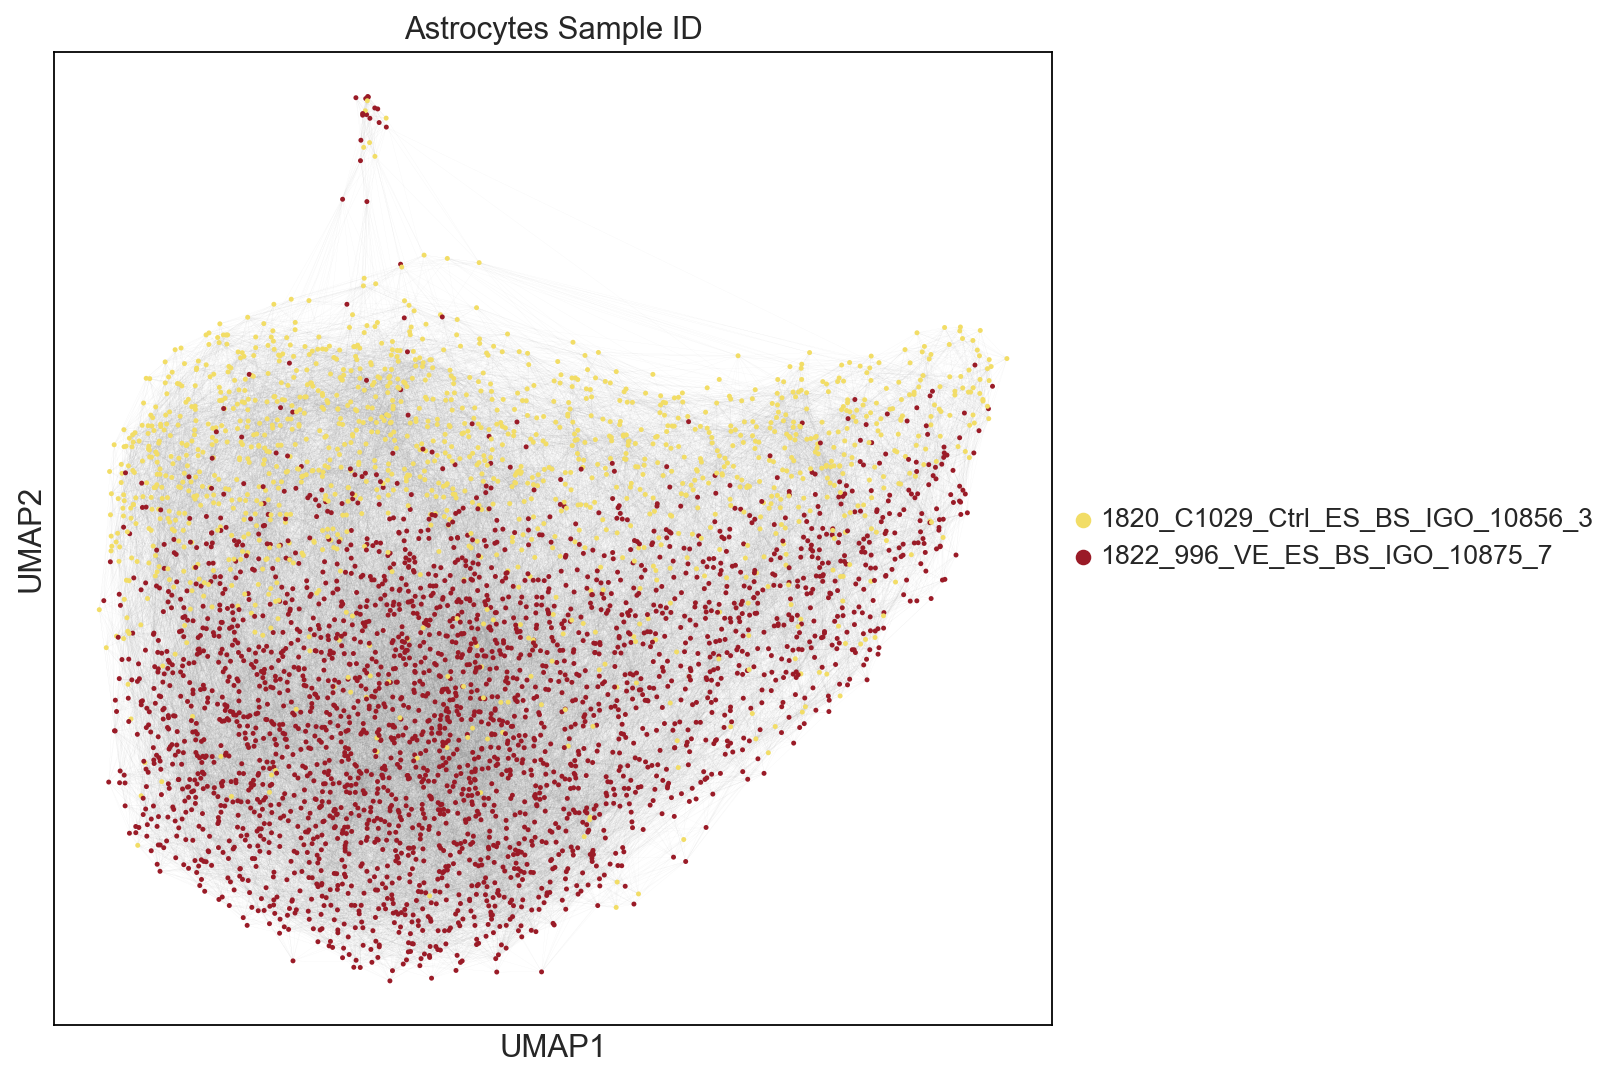

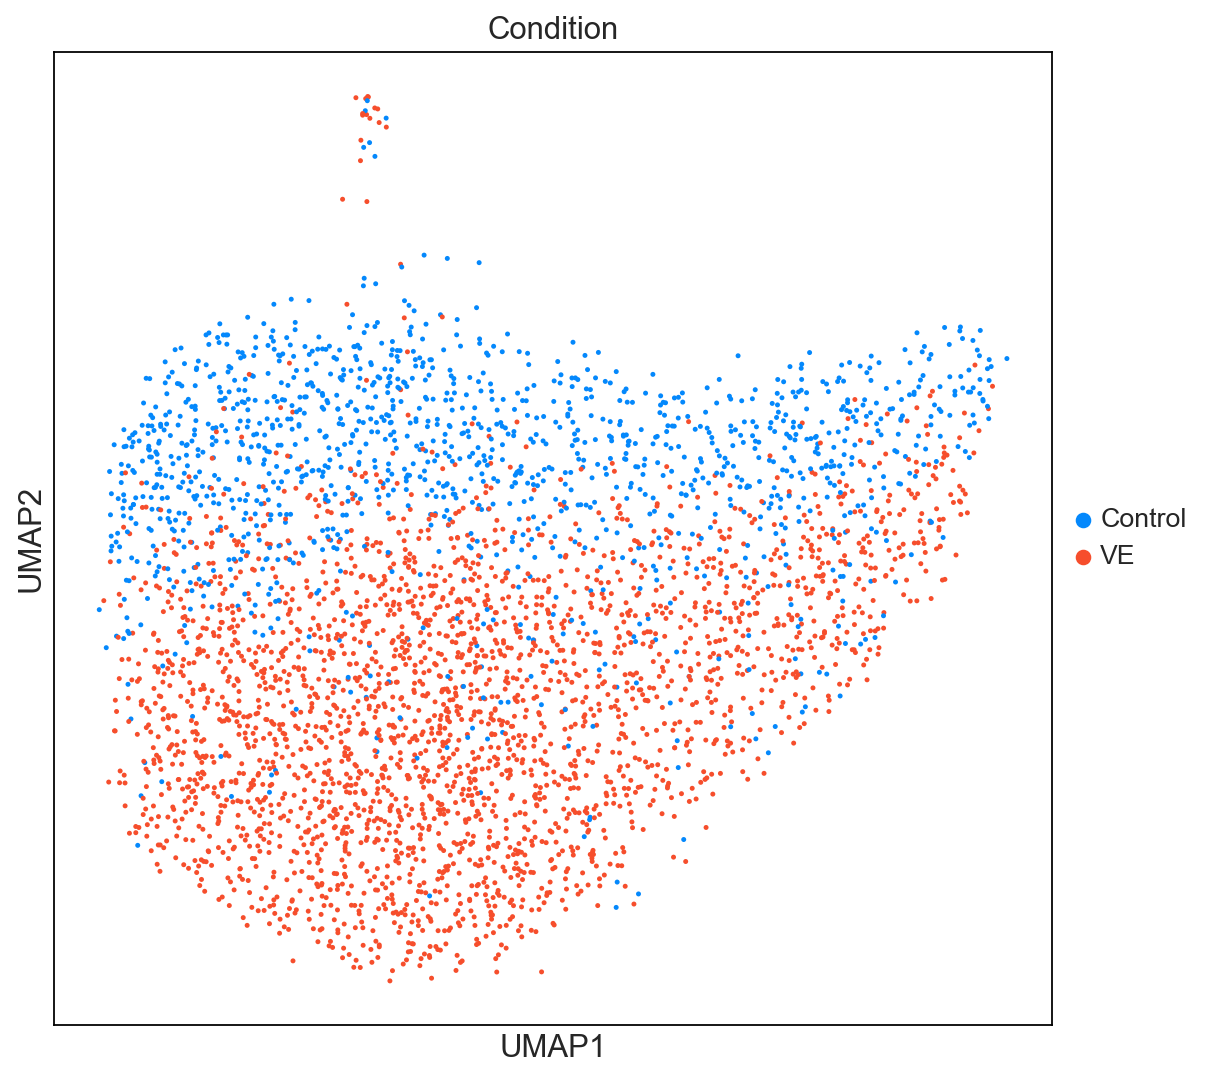

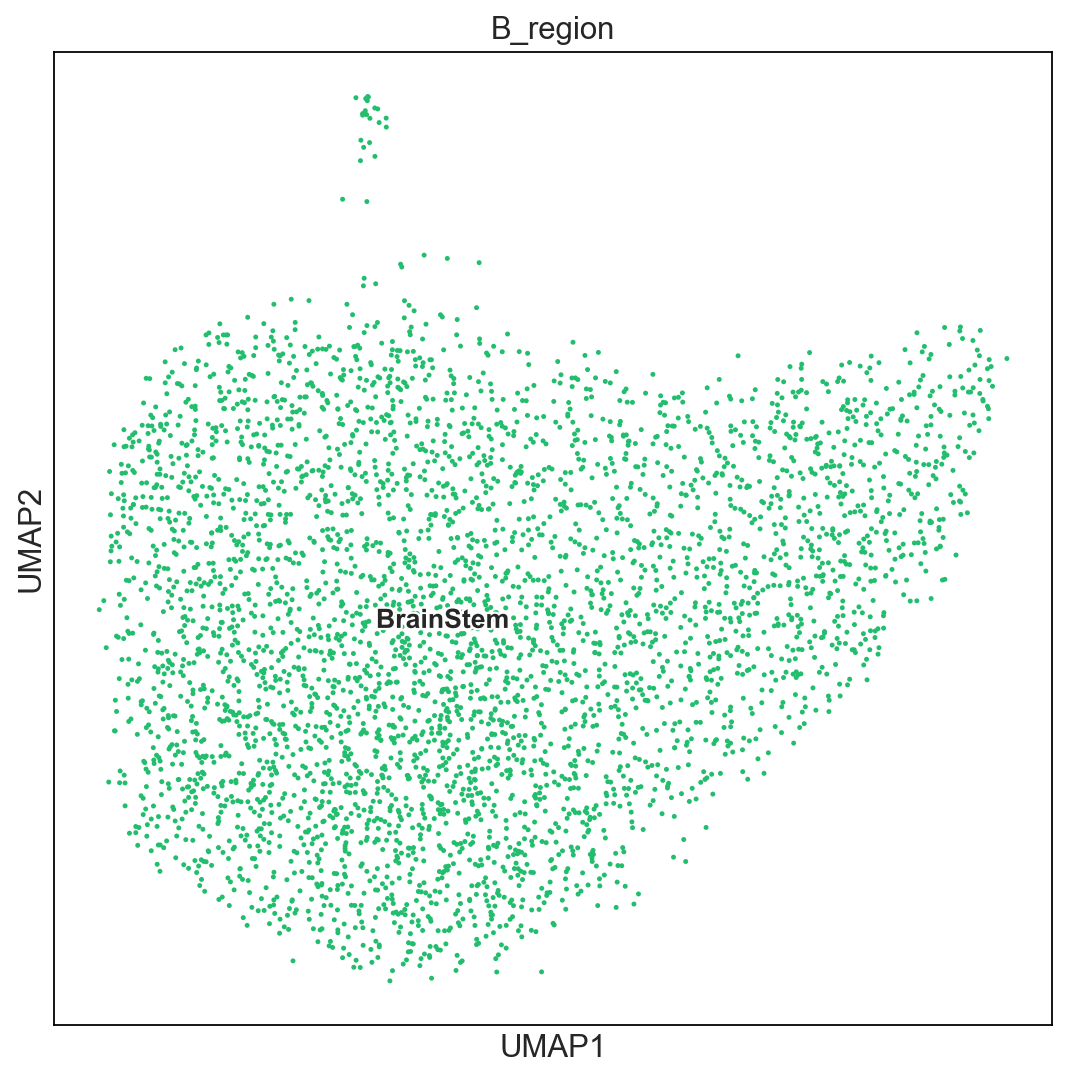

In [27]:
sc.pl.umap(adata_oligo_BS,
           color=['PhenoGraph_clusters_oligo_BS'],
           ncols=2,
           sort_order=False,
           palette=godsnot_64, # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2,)

sc.pl.umap(adata_oligo_BS, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=20, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_oligo_BS,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2)

sc.pl.umap(adata_oligo_BS,
           color=['B_region'],
           ncols=2,
           sort_order=False,
           palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2)



## Find markers (Oligo clusters)

In [28]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Oligo_BS_0',
    1 : 'Oligo_BS_1',
    2 : 'Oligo_BS_2',
    3 : 'Oligo_BS_3',
    4 : 'Oligo_BS_4',
    5 : 'Oligo_BS_5',
    6 : 'Oligo_BS_6'}

adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS_str'] = adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'].map(cl_int_to_str).astype('category')

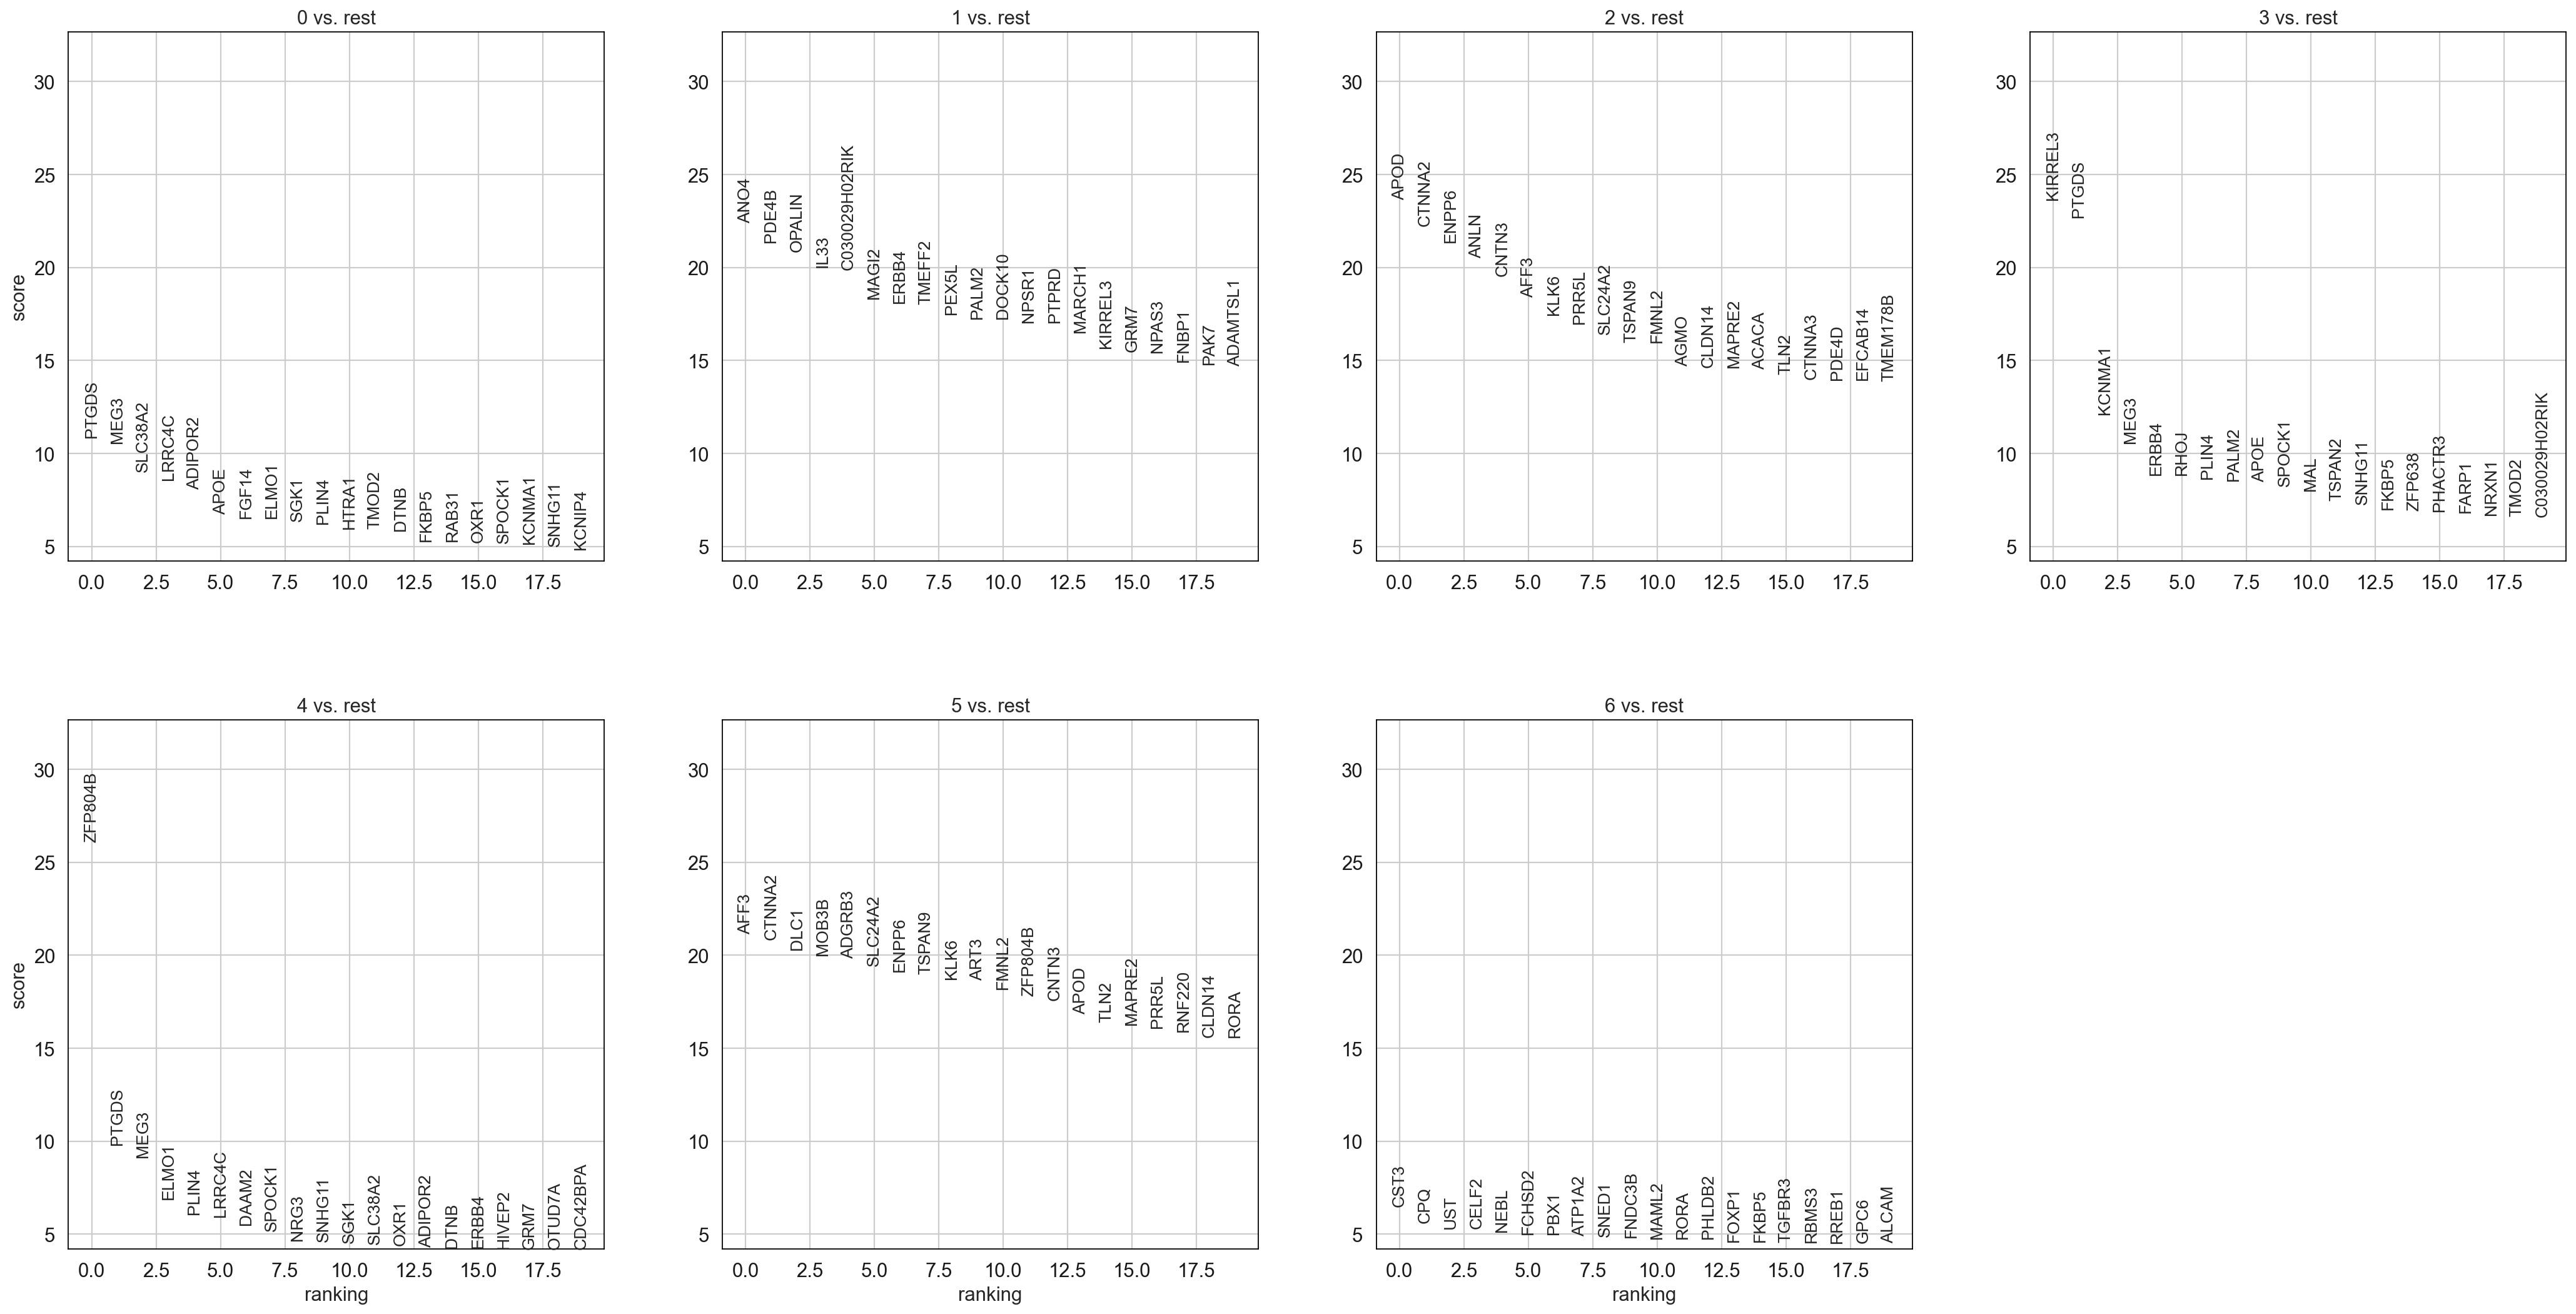

In [29]:
sc.tl.rank_genes_groups(adata_oligo_BS, groupby='PhenoGraph_clusters_oligo_BS', key_added="ranked_genes_pheno_oligo", method='wilcoxon')
sc.pl.rank_genes_groups(adata_oligo_BS, key = 'ranked_genes_pheno_oligo', fontsize=12)

In [30]:
adata_oligo_BS.obs.PhenoGraph_clusters_oligo_BS_str.value_counts()

Oligo_BS_0    981
Oligo_BS_1    937
Oligo_BS_2    753
Oligo_BS_3    677
Oligo_BS_4    460
Oligo_BS_5    286
Oligo_BS_6     38
Name: PhenoGraph_clusters_oligo_BS_str, dtype: int64

In [31]:
adata_oligo_BS.obs.PhenoGraph_clusters_oligo_BS_str.value_counts()

Oligo_BS_0    981
Oligo_BS_1    937
Oligo_BS_2    753
Oligo_BS_3    677
Oligo_BS_4    460
Oligo_BS_5    286
Oligo_BS_6     38
Name: PhenoGraph_clusters_oligo_BS_str, dtype: int64

## Visualize marker genes using heatmap

In [32]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_oligo_BS_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

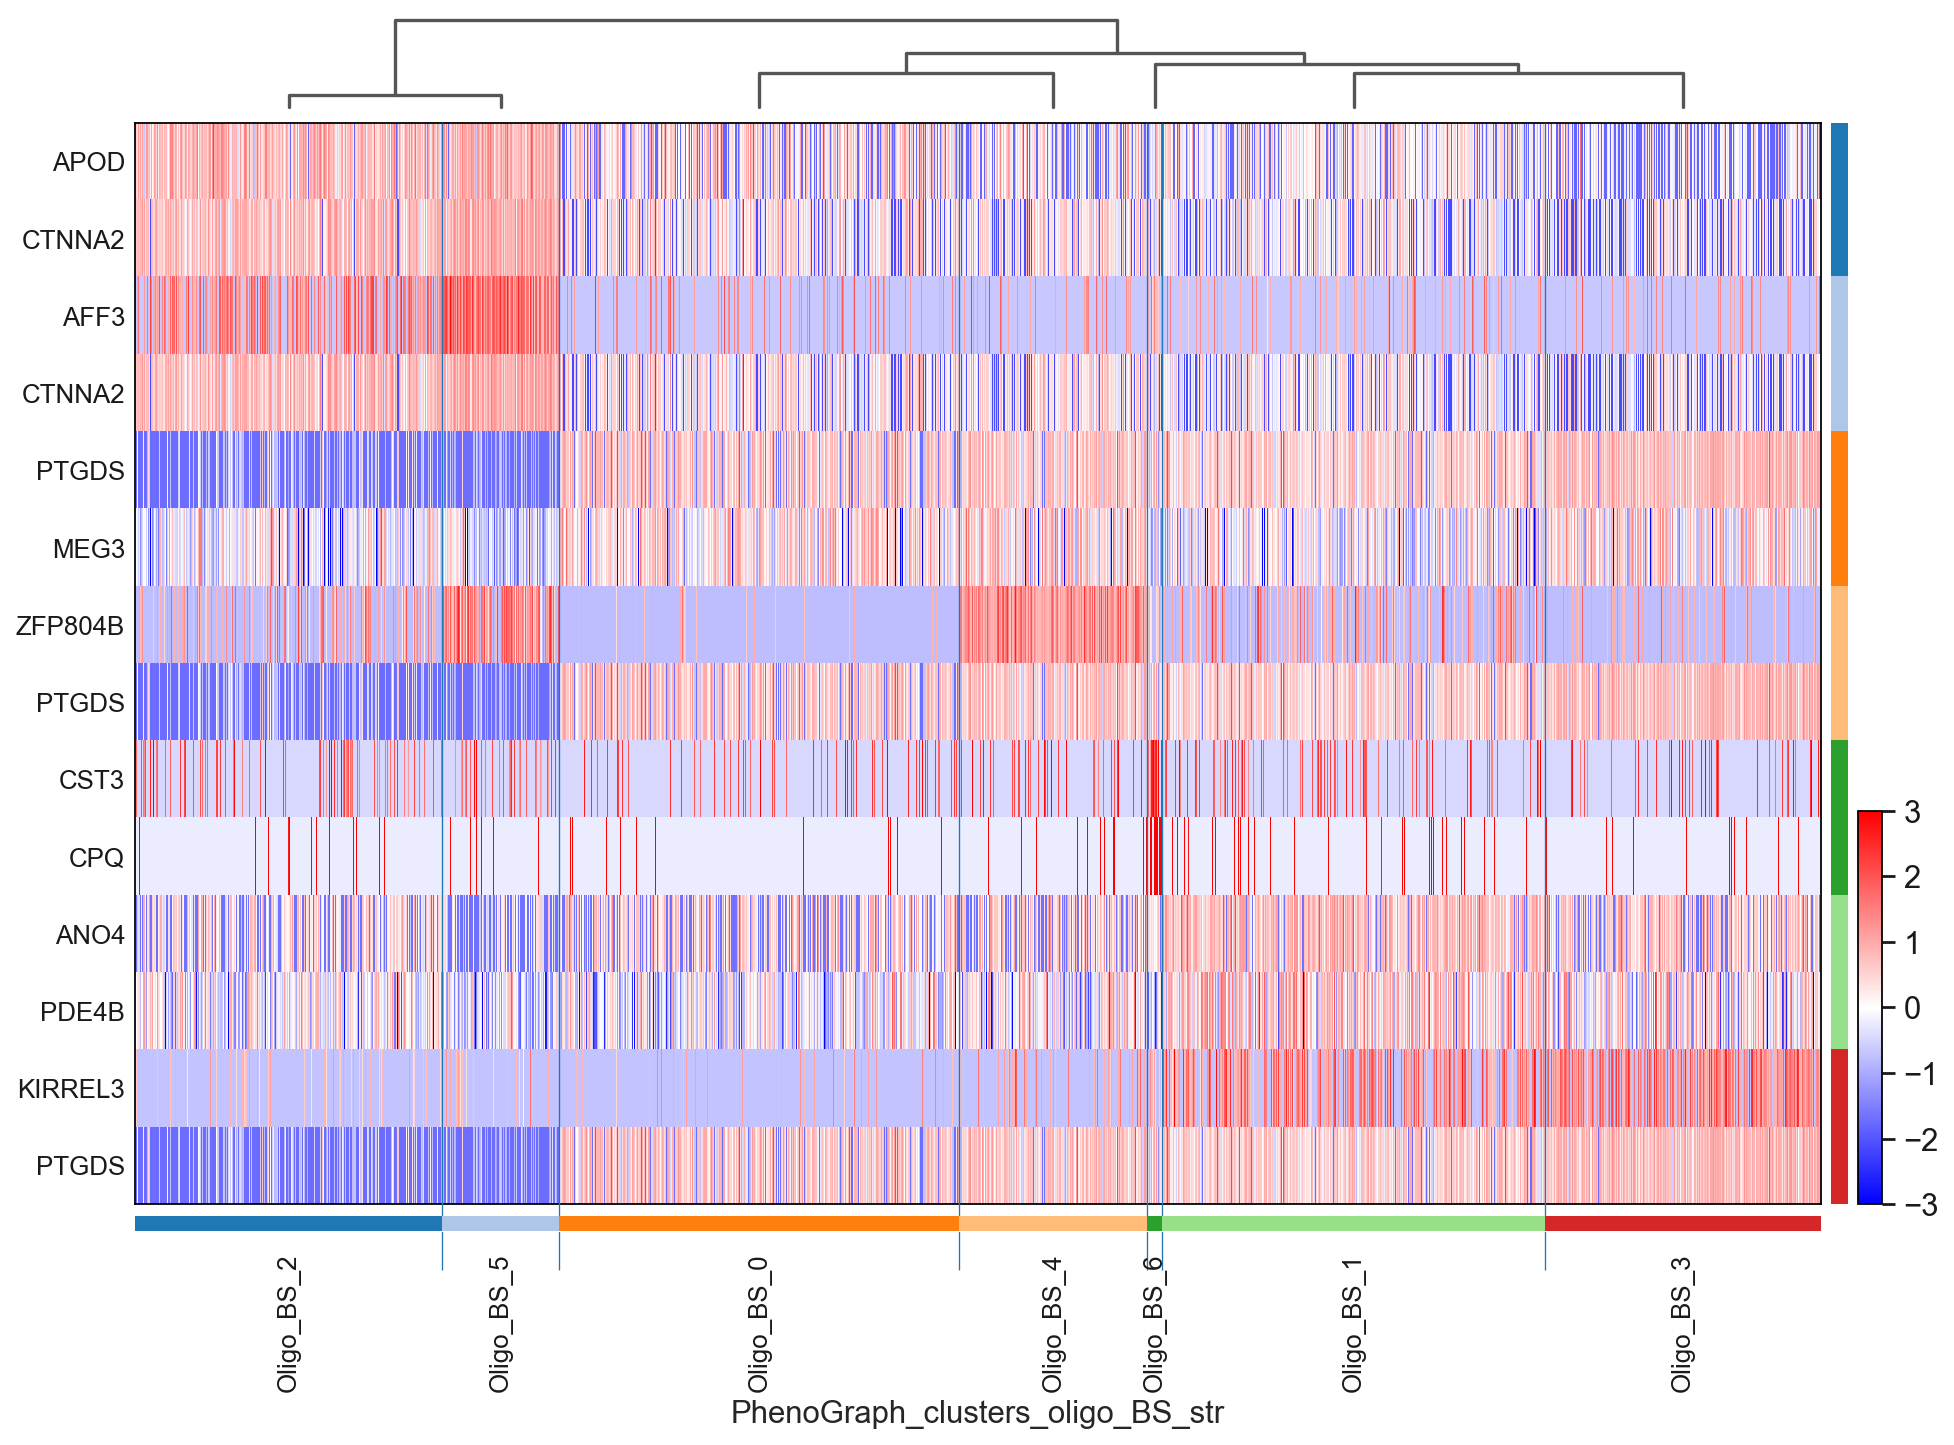

In [33]:
sc.tl.rank_genes_groups(adata_oligo_BS, groupby='PhenoGraph_clusters_oligo_BS_str', n_genes=adata_oligo_BS.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_oligo_BS, n_genes=2, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


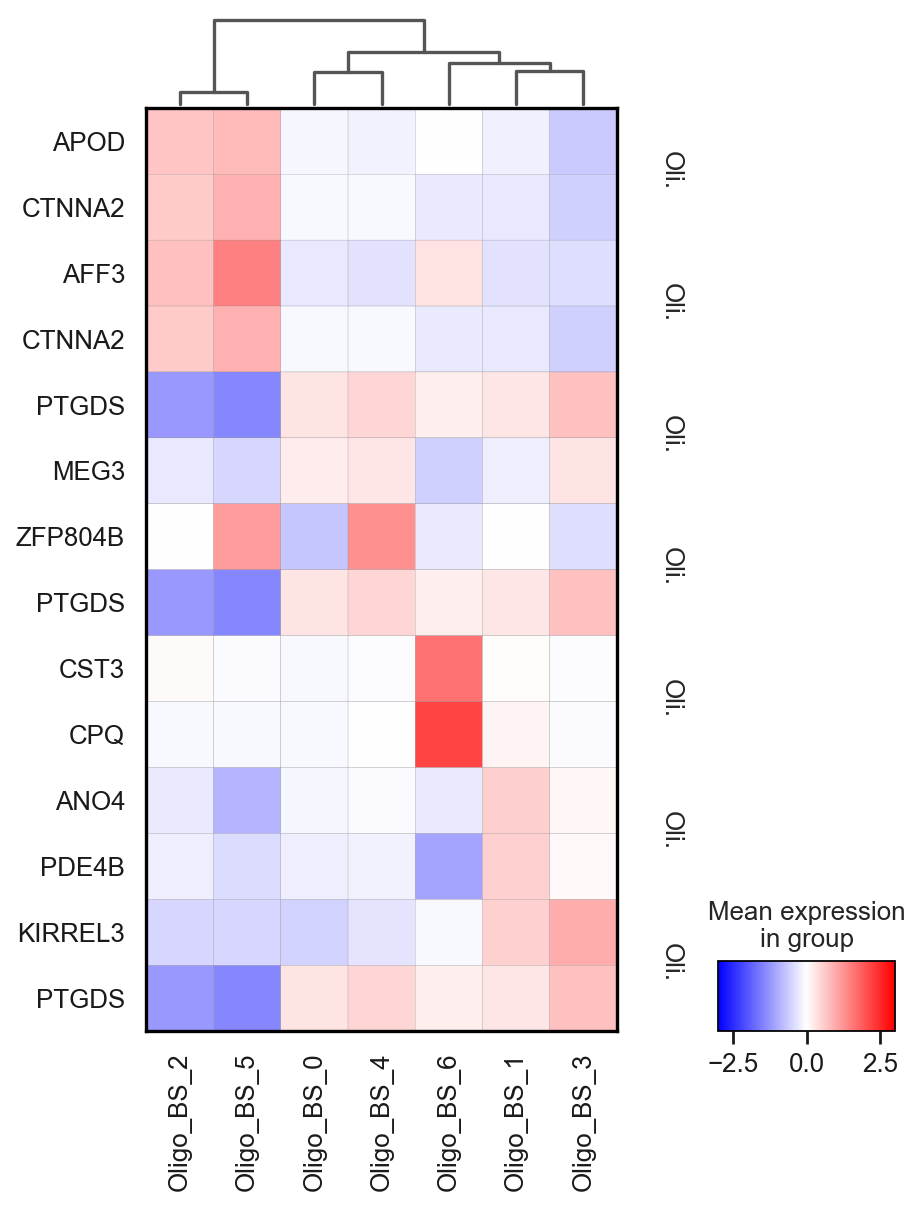

In [185]:
sc.pl.rank_genes_groups_matrixplot(adata_oligo_BS, n_genes=2, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(6,8))

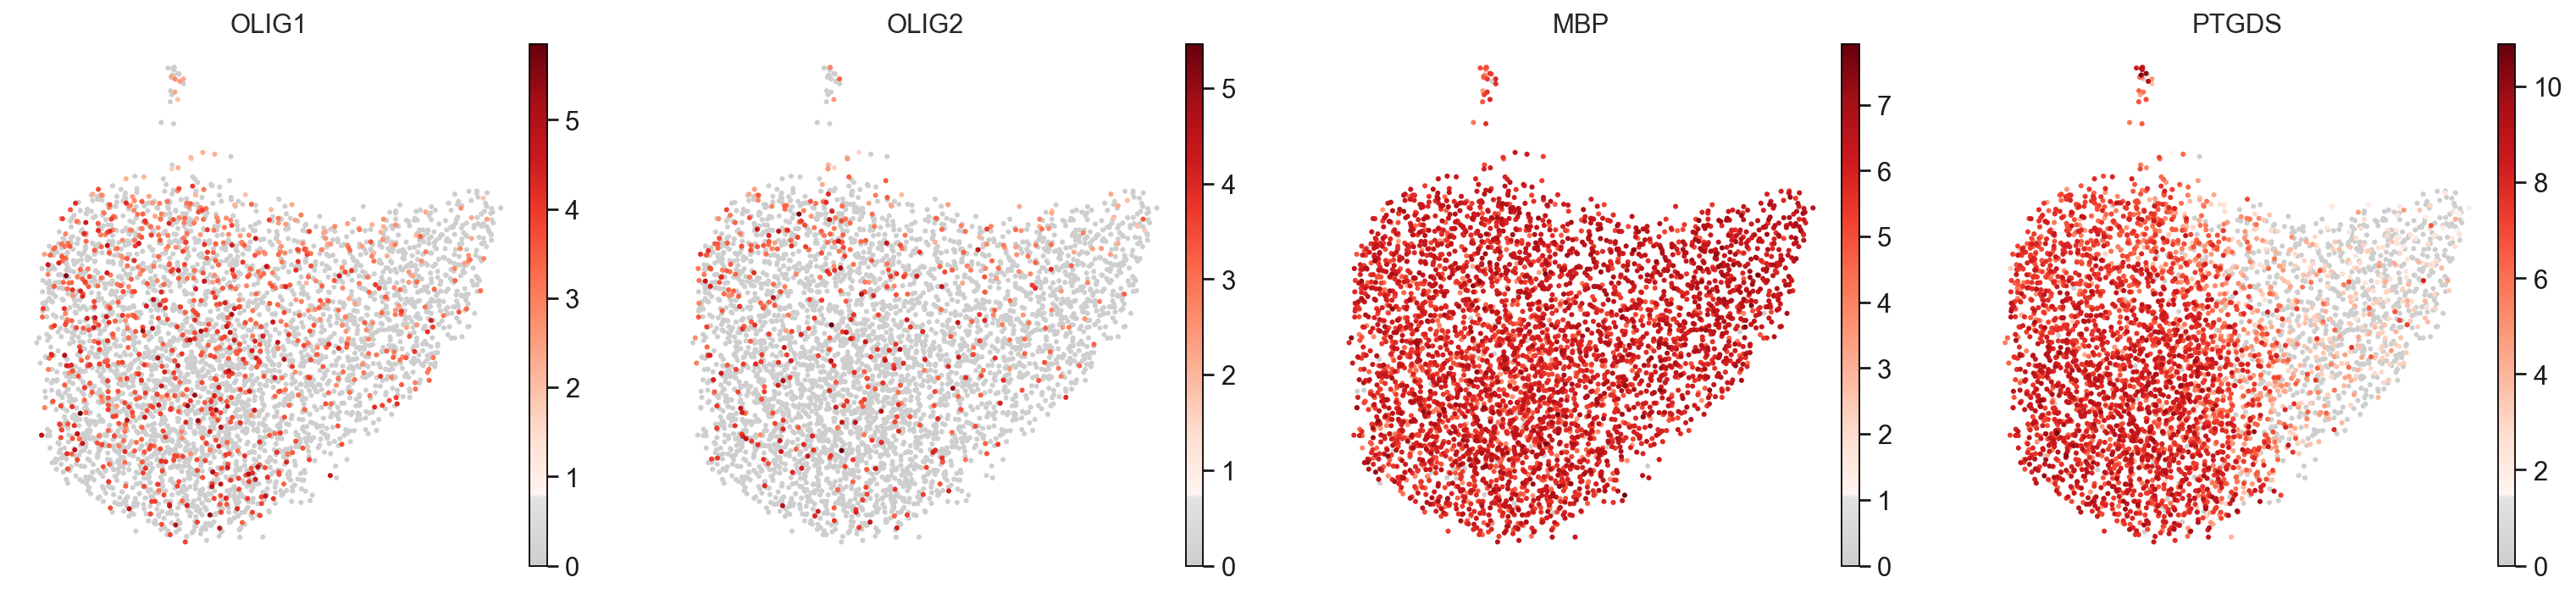

In [34]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_oligo_BS,
           size = 30,
           color=['OLIG1','OLIG2','MBP','PTGDS'],
           color_map=mymap,
          frameon=False, )

**PTGDS expression**

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


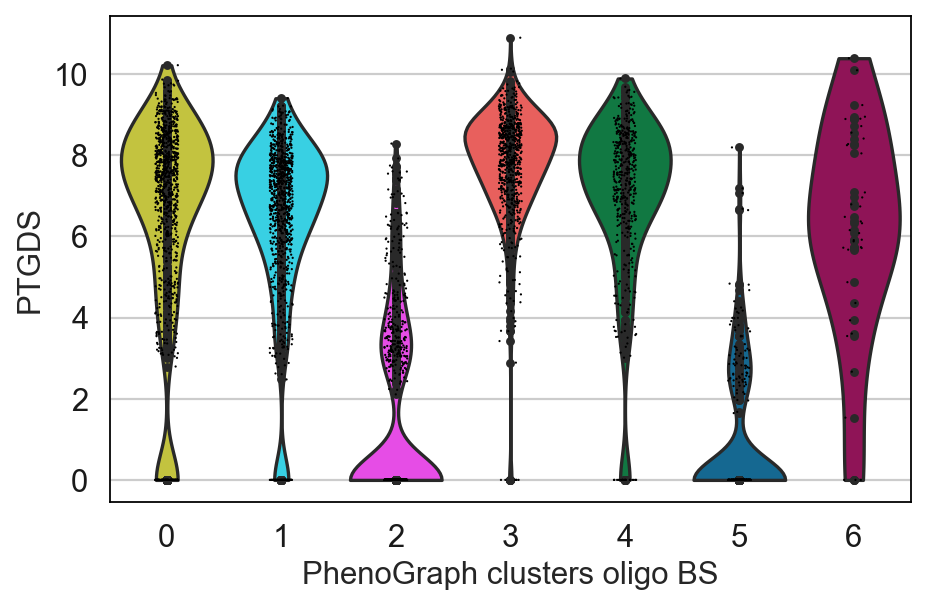

In [36]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.violin(adata_oligo_BS, ['PTGDS'], groupby='PhenoGraph_clusters_oligo_BS', inner='point', palette = godsnot_64)

# Save result Adata Oligodendrocytes

In [37]:
#adata_oligo_BS.write_h5ad(outdir+'adata_high_var_Oligo_Brainstem_clusters.h5ad')

Load the adata object that holds the latest cell type annotations..

In [11]:
#adata_oligo_BS = sc.read_h5ad(outdir+'adata_high_var_Oligo_Brainstem_clusters.h5ad')

# Differential expression with MAST (BS ALL samples)

Oligodendrocytes Brainstem clusters only

In [42]:
run_MAST_for_celltype_condition(adata_oligo_BS, "Oligodendrocytes")

Oligodendrocytes	Dimensions	(4132, 13186)
Files written for Oligodendrocytes
Running ./runMAST_condition.R ../DEA/Oligodendrocytes/adata_Oligodendrocytes_exp_mat.csv ../DEA/Oligodendrocytes/adata_Oligodendrocytes_cdata.csv ../DEA/Oligodendrocytes/MAST_DEA_Oligodendrocytes_RESULTS.csv


'Finished running MAST on( Oligodendrocytes) in 583.0220444840002 seconds.'

In [44]:
# import the MAST results
adata_oligo_BS_res = pd.read_csv (filepath_or_buffer= '../DEA/Oligodendrocytes_Brainstem/MAST_DEA_Oligodendrocytes_RESULTS.csv')
print(adata_oligo_BS_res)

         gene              p      p.fdr.adj     logFC
0      TMEFF2  4.564747e-112  6.019076e-108 -0.820740
1       FKBP5  1.166821e-108  7.692853e-105  1.245794
2       PTPRD  2.556213e-108  1.123541e-104 -0.646317
3       FNBP1  4.619714e-108  1.522889e-104 -0.974108
4       PDE4B  1.321432e-107  3.484881e-104 -0.622048
...       ...            ...            ...       ...
13181   DDX11   9.995378e-01   9.997807e-01 -0.000213
13182  ZFP689   9.995532e-01   9.997807e-01  0.000182
13183   LYRM5   9.996456e-01   9.997972e-01 -0.000006
13184  P2RY12   9.999224e-01   9.999983e-01  0.000032
13185  RIIAD1   1.000000e+00   1.000000e+00 -0.000083

[13186 rows x 4 columns]


In [48]:
 adata_oligo_BS_res[adata_oligo_BS_res['p.fdr.adj'] <= 0.05]

gene              p      p.fdr.adj     logFC
0     TMEFF2  4.564747e-112  6.019076e-108 -0.820740
1      FKBP5  1.166821e-108  7.692853e-105  1.245794
2      PTPRD  2.556213e-108  1.123541e-104 -0.646317
3      FNBP1  4.619714e-108  1.522889e-104 -0.974108
4      PDE4B  1.321432e-107  3.484881e-104 -0.622048
...      ...            ...            ...       ...
4664   CTPS2   1.757775e-02   4.968493e-02  0.015214
4665   MDFIC   1.760417e-02   4.974895e-02  0.016055
4666    KDM8   1.763702e-02   4.983109e-02 -0.039314
4667   MPV17   1.766207e-02   4.989118e-02  0.039784
4668   TBX15   1.766886e-02   4.989968e-02  0.014651

[4669 rows x 4 columns]

In [53]:
#filter DE results
adata_oligo_BS_res = adata_oligo_BS_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
adata_oligo_BS_res_UP = adata_oligo_BS_res[(adata_oligo_BS_res['logFC'] >=0.01) & (adata_oligo_BS_res['p.fdr.adj'] <= 0.05)]
adata_oligo_BS_res_DOWN = adata_oligo_BS_res[(adata_oligo_BS_res['logFC'] <=0.01) & (adata_oligo_BS_res['p.fdr.adj'] <= 0.05)]
#mast_C0_res_UP['gene'].head(20)
adata_oligo_BS_res_UP.shape

(2533, 4)

## ALL clusters Enrichr 

In [88]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

adata_oligo_BS_res_UP_n_list = adata_oligo_BS_res_UP.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=adata_oligo_BS_res_UP_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [89]:
enr_res.results.head(10)

Gene_set                                         Term Overlap  \
0  KEGG_2019_Mouse                                    Autophagy  48/130   
1  KEGG_2019_Mouse               Ubiquitin mediated proteolysis  49/138   
2  KEGG_2019_Mouse  Protein processing in endoplasmic reticulum  52/163   
3  KEGG_2019_Mouse                       FoxO signaling pathway  40/132   
4  KEGG_2019_Mouse                            Pancreatic cancer   27/75   
5  KEGG_2019_Mouse                 Choline metabolism in cancer   31/99   
6  KEGG_2019_Mouse                                    Mitophagy   23/63   
7  KEGG_2019_Mouse                           Lysine degradation   22/59   
8  KEGG_2019_Mouse                    mRNA surveillance pathway   30/96   
9  KEGG_2019_Mouse               Neurotrophin signaling pathway  35/121   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.460910e-12      4.178204e-10            0                     0   
1  4.599505e-12      6.577292e-10            0                     0   
2  1.035663e-10      9.873322e-09            0                     0   
3  7.089317e-08      5.068861e-06            0                     0   
4  2.011407e-07      1.150525e-05            0                     0   
5  9.239791e-07      4.387470e-05            0                     0   
6  1.193041e-06      4.387470e-05            0                     0   
7  1.338606e-06      4.387470e-05            0                     0   
8  1.443597e-06      4.387470e-05            0                     0   
9  1.534080e-06      4.387470e-05            0                     0   

   Odds Ratio  Combined Score  \
0    4.095205      111.602378   
1    3.851716      100.549329   
2    3.277202       75.345530   
3    3.030224       49.883822   
4    3.909891       60.287634   
5    3.170223       44.048901   
6    3.992241       54.450194   
7    4.127353       55.817837   
8    3.160026       42.497210   
9    2.831731       37.910017   

                                               Genes  
0  BECN1;RAB7;MTMR3;IRS1;PIK3R4;ITPR1;IRS2;PIK3CB...  
1  UBE3C;UBE2Z;UBE2L3;HERC3;HERC1;UBE2Q2;BTRC;SKP...  
2  TRAM1;HSP90AB1;NGLY1;HERPUD1;MAN1A2;SKP1A;PDIA...  
3  CDKN1A;IRS1;SETD7;PRKAG2;IRS2;PIK3CB;STK4;EGFR...  
4  RB1;CDKN1A;PIK3CB;EGFR;CDC42;MAPK9;MAPK8;MAPK1...  
5  DGKB;PDGFA;PIK3CB;EGFR;MAPK9;NRAS;MAPK8;PDGFD;...  
6  USP8;BECN1;RAB7;CSNK2A1;TFEB;AMBRA1;MAPK10;BCL...  
7  KMT2E;SETD2;SETD3;ECHS1;KMT2A;SETDB1;PRDM6;EHM...  
8  DAZAP1;SMG1;CASC3;SMG5;GSPT1;PPP1CB;PNN;PPP1CC...  
9  YWHAE;CAMK2D;IRS1;PIK3CB;RAP1B;CDC42;MAPK9;NRA...

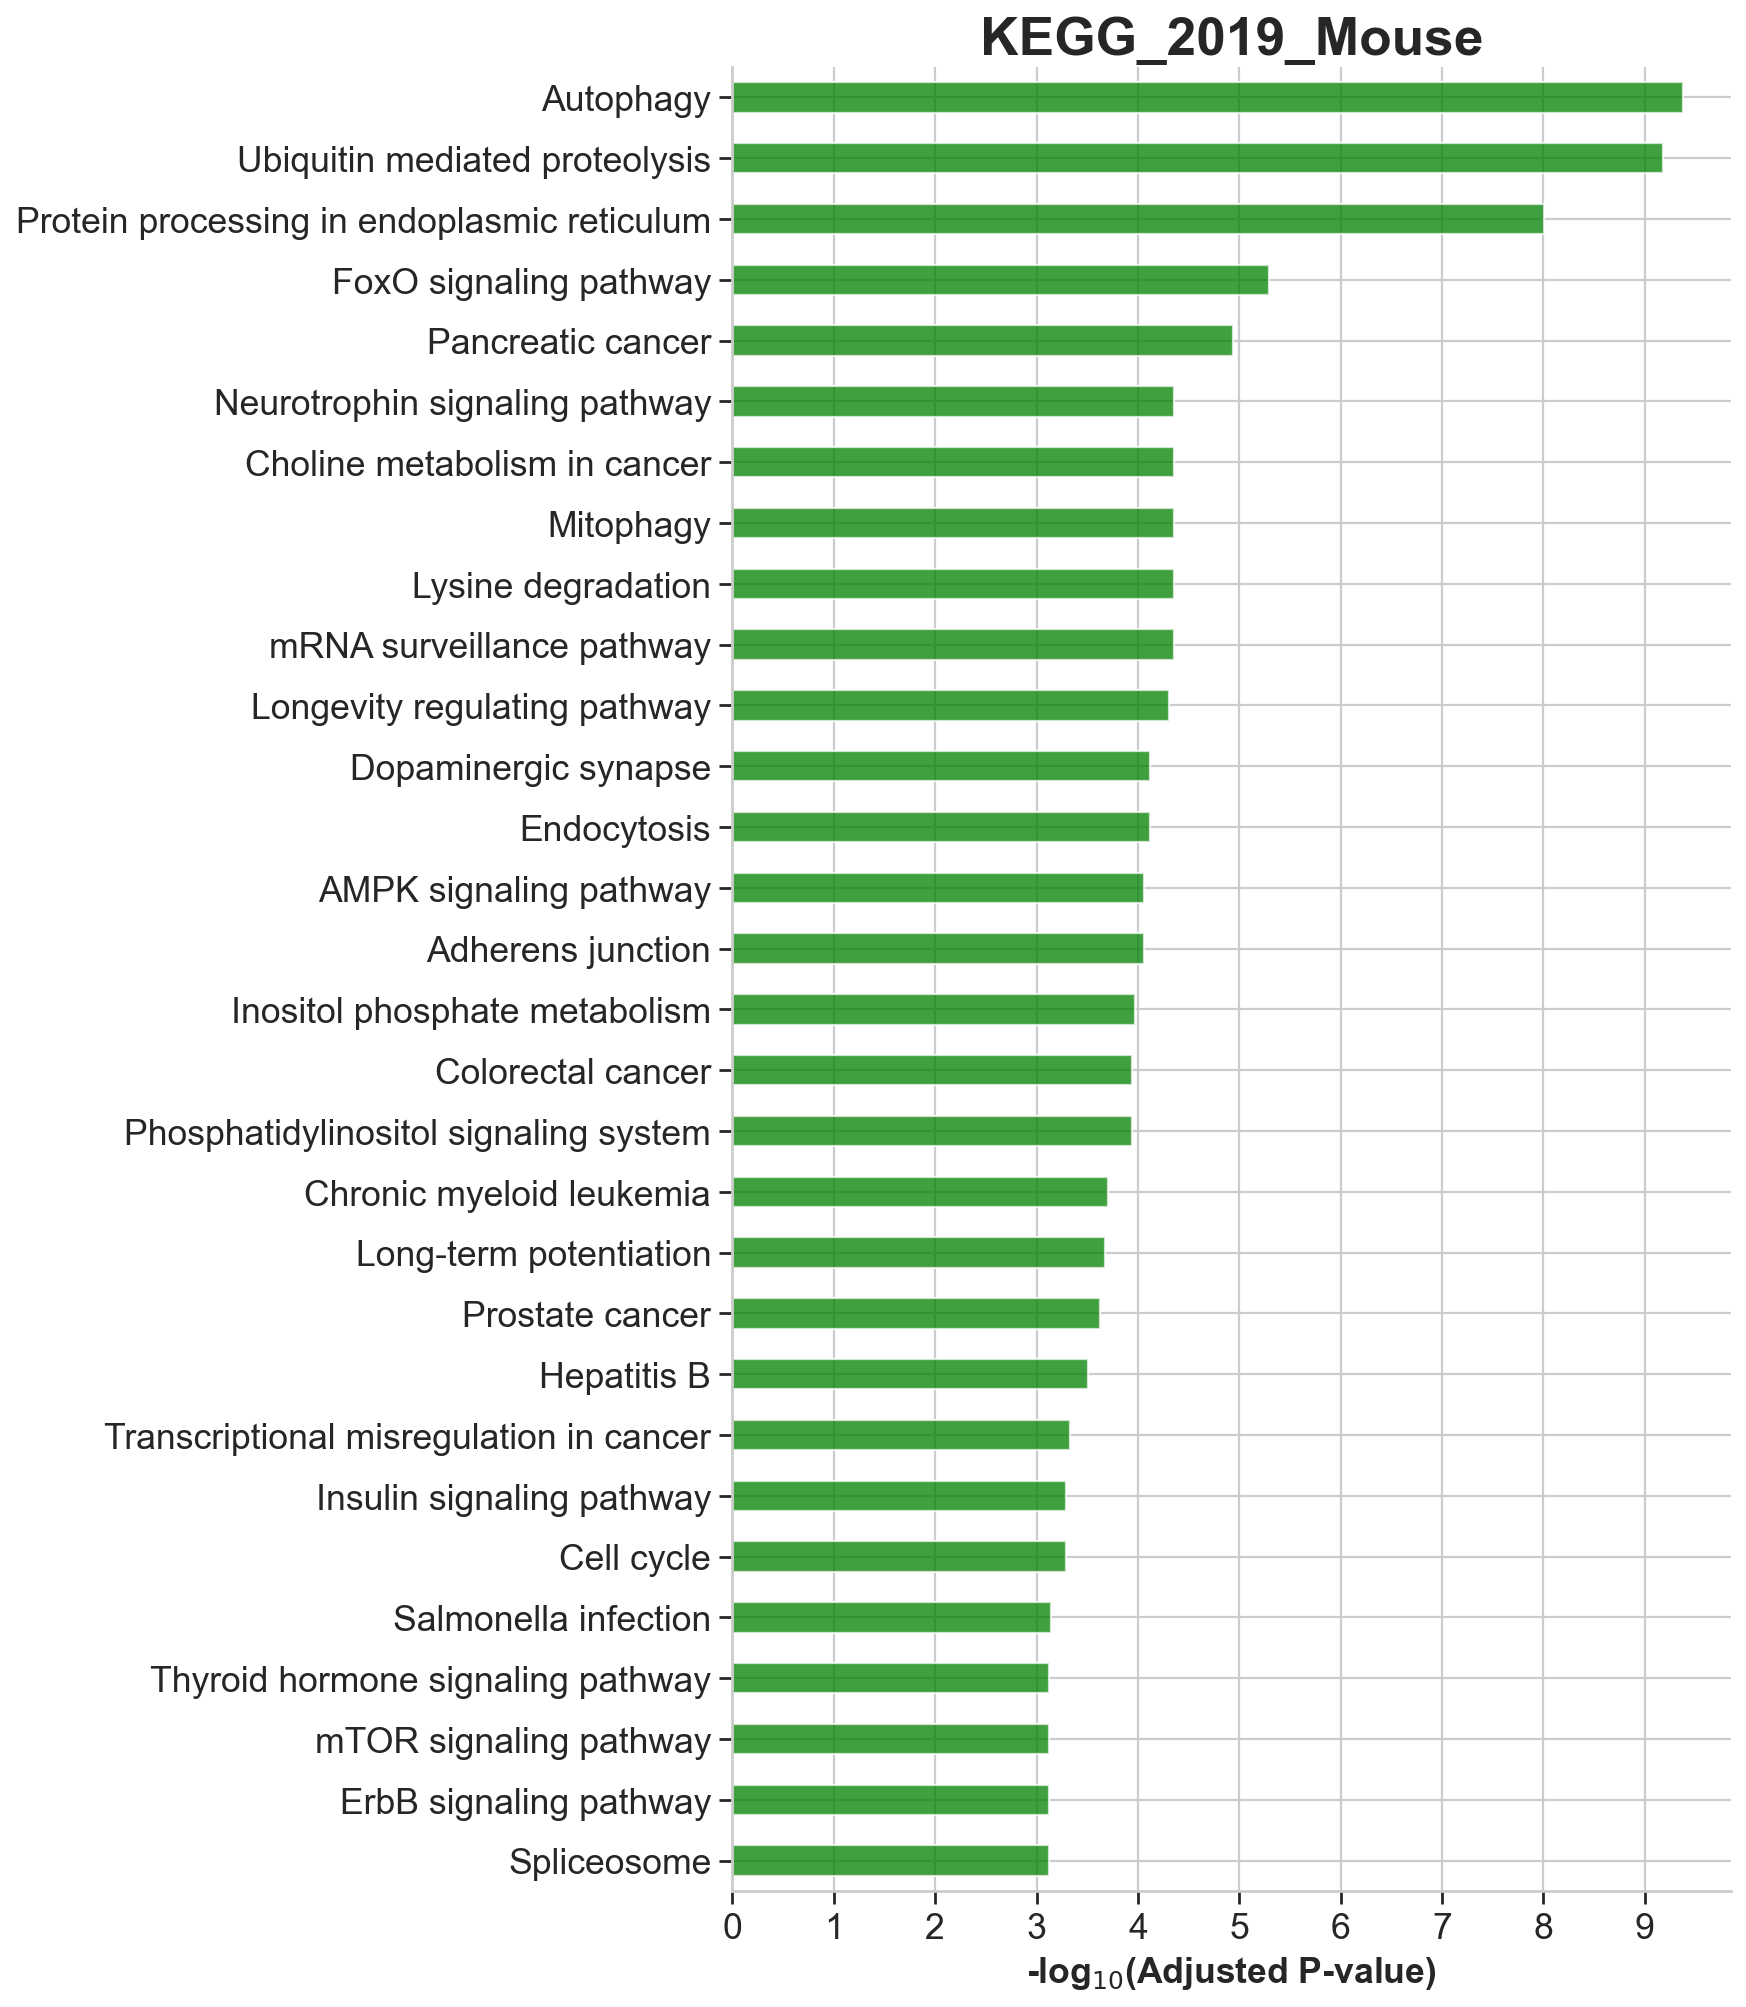

In [95]:
gseapy.barplot(enr_res.res2d,title='KEGG_2019_Mouse',top_term=30,color='green',figsize=(8,15))

## Heatmaps of gene expression of top DEA genes

### All Brainstem samples

In [54]:
marker_genes_dict = dict()

marker_genes_dict = {'Oligo-BS': adata_oligo_BS_res_UP['gene'].head(20)}

categories: Oligo_BS_0_Control, Oligo_BS_0_VE, Oligo_BS_1_Control, etc.
var_group_labels: Oligo-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


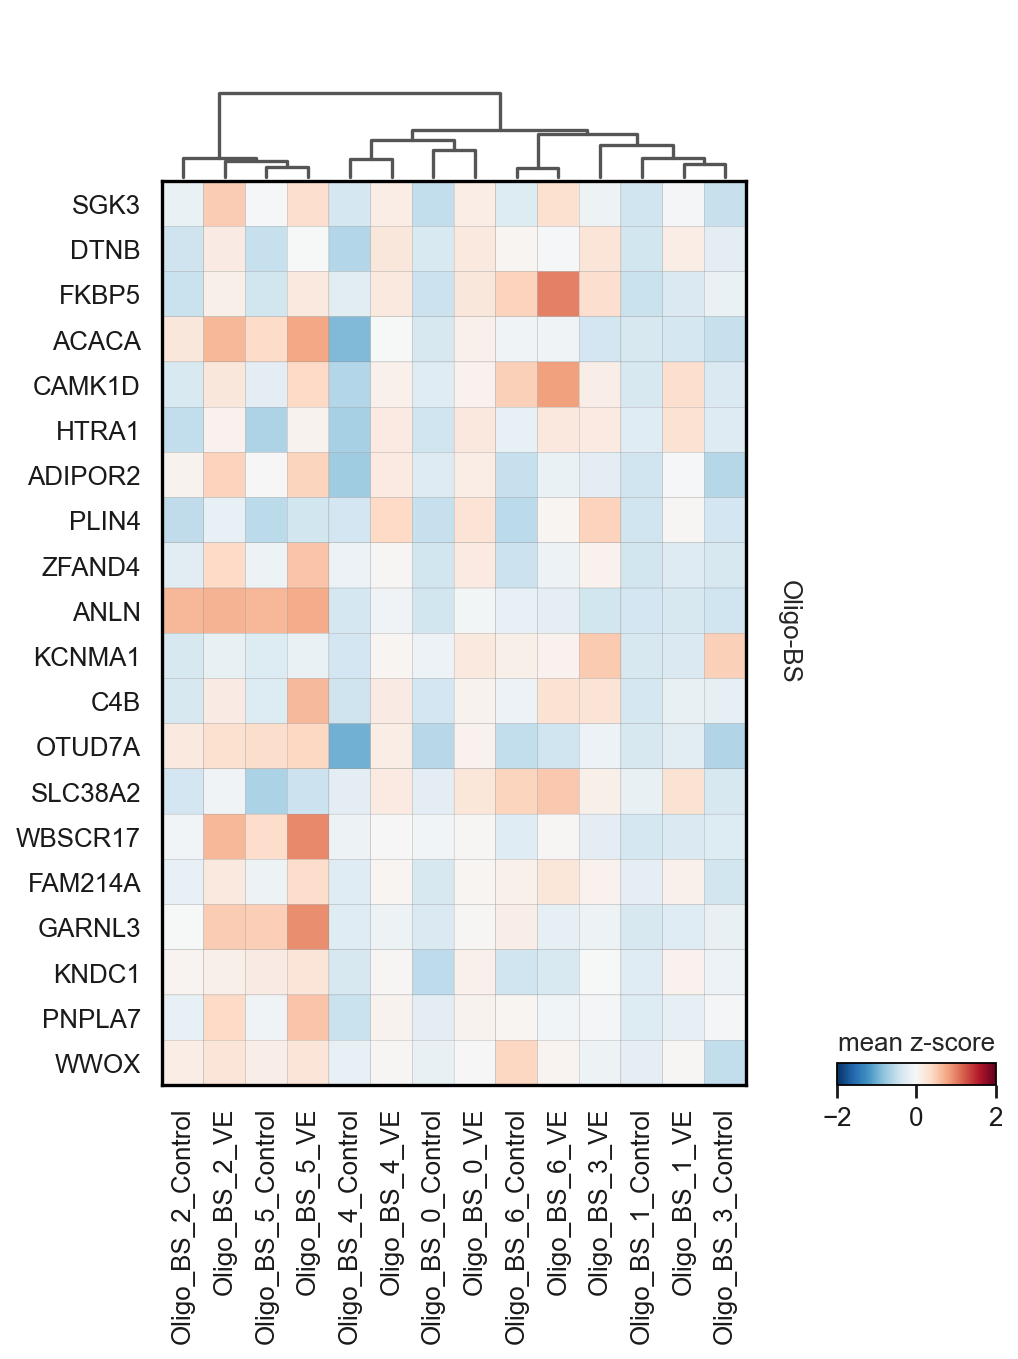

categories: Oligo_BS_0_Control, Oligo_BS_0_VE, Oligo_BS_1_Control, etc.
var_group_labels: Oligo-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


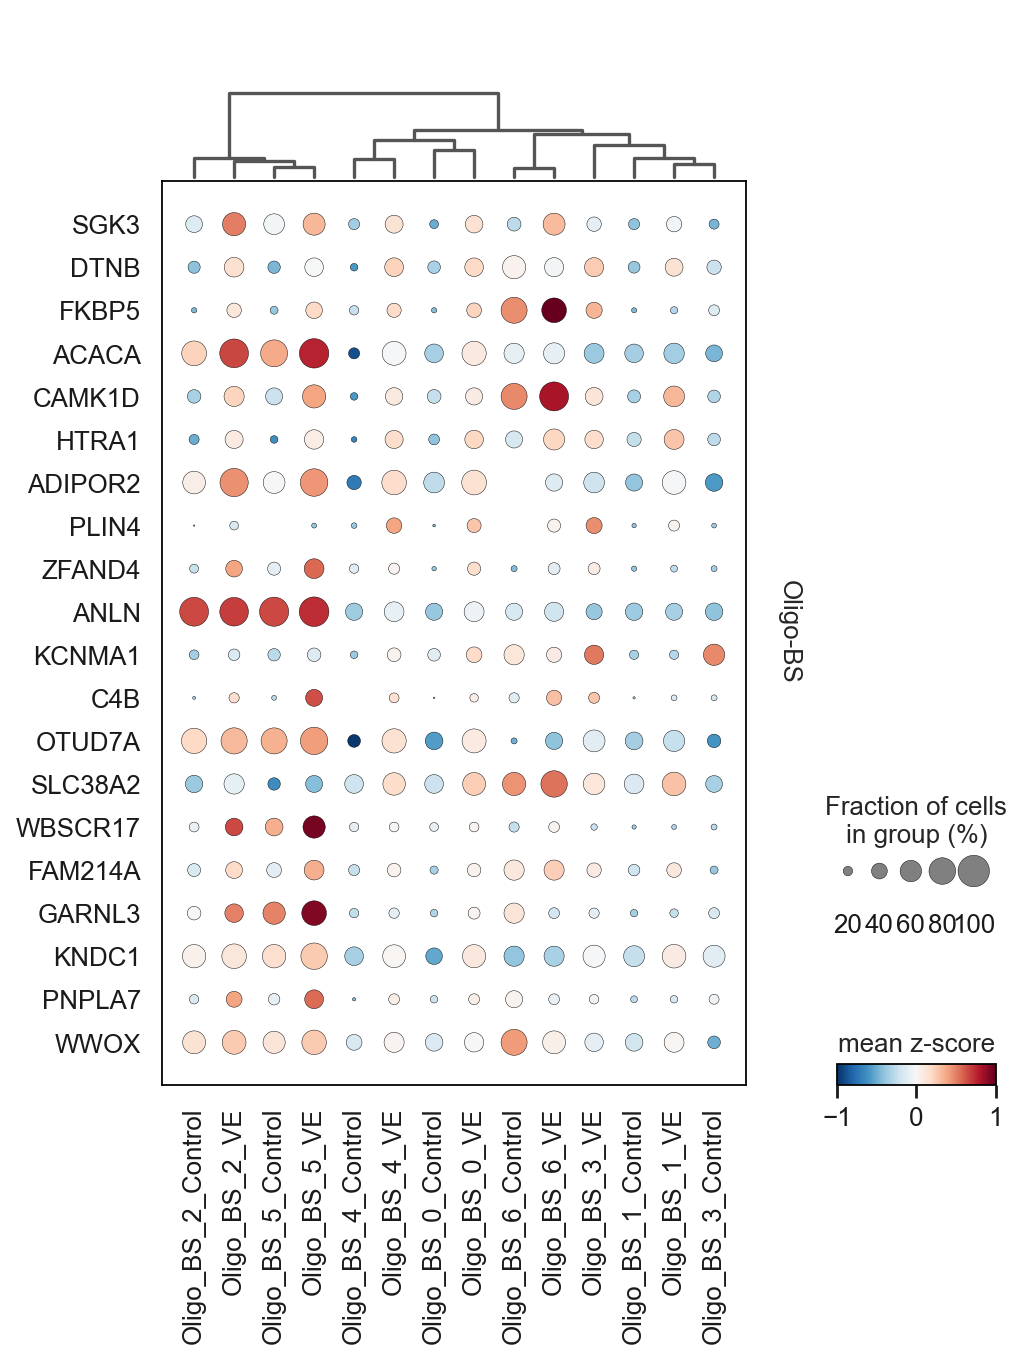

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


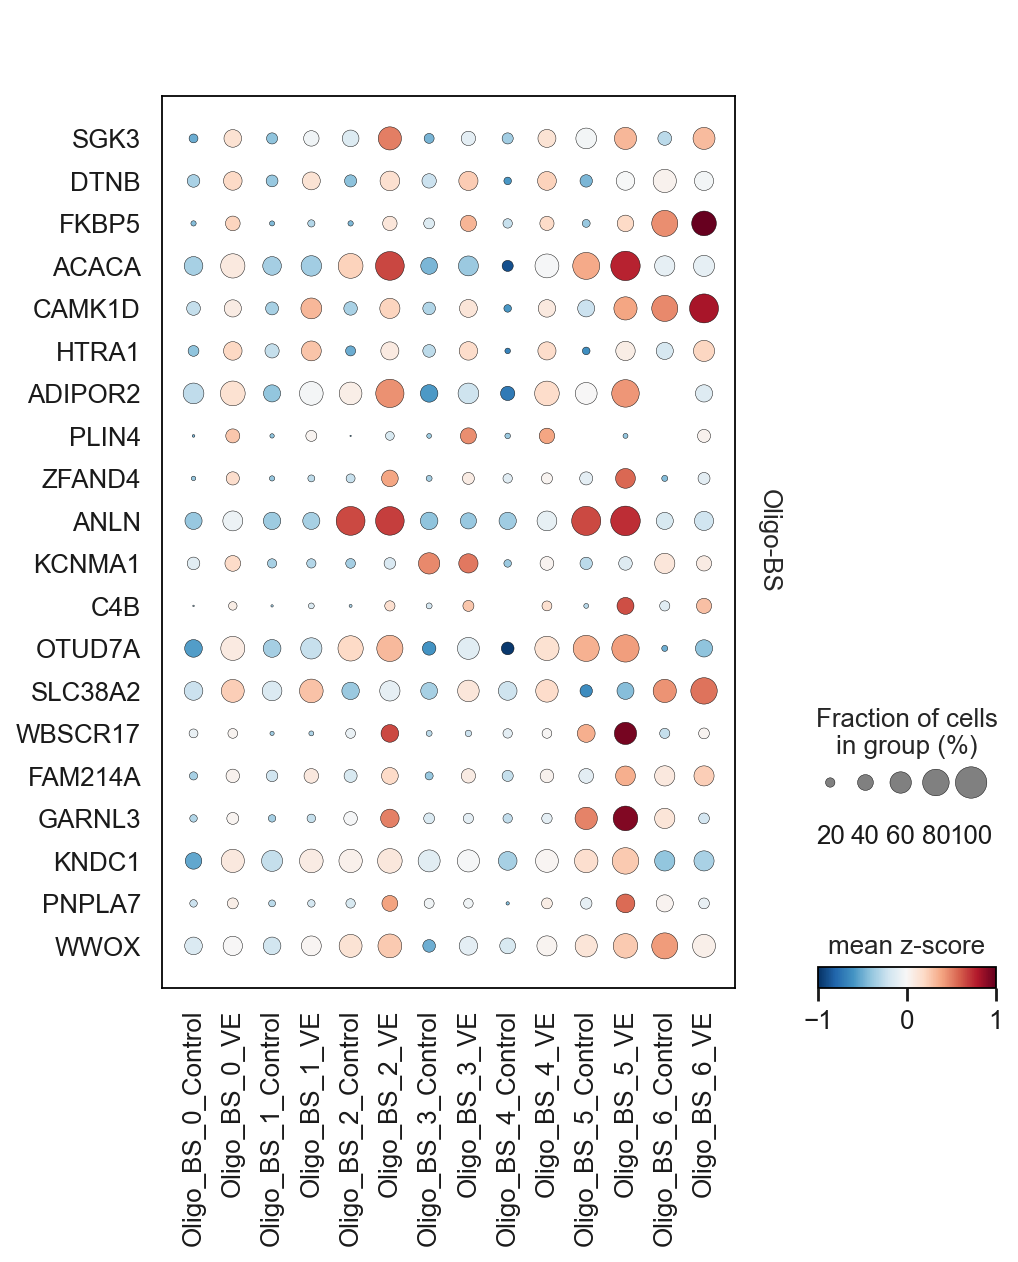

In [60]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X
sc.pl.matrixplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

In [ ]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.violin(adata_oligo_BS, ['PTGDS'], groupby='PhenoGraph_clusters_oligo_str', inner='point', palette = godsnot_64)

# Oligodendrocytes BS control 

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


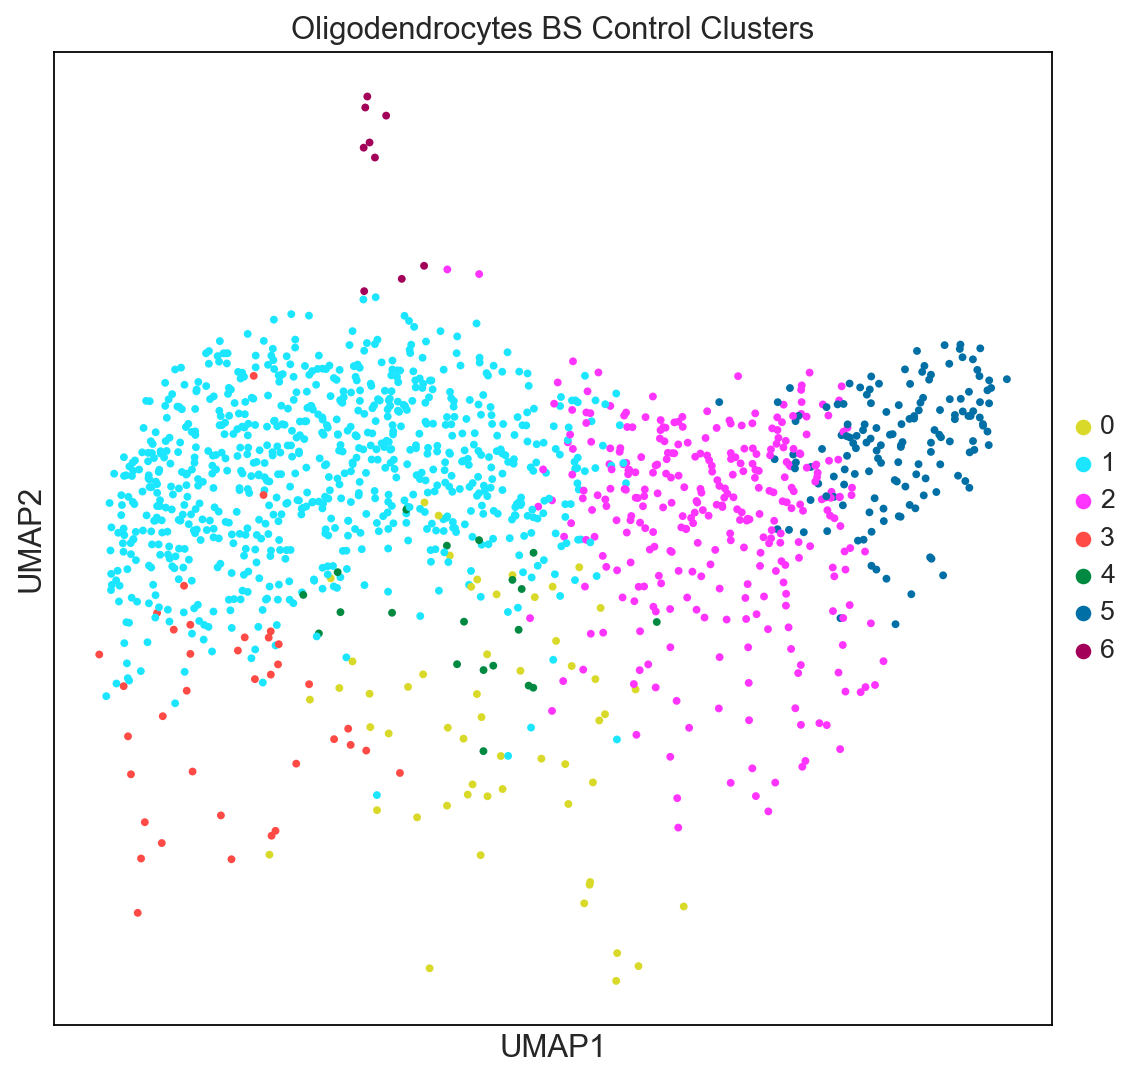

In [61]:
adata_oligo_BS_control = adata_oligo_BS[adata_oligo_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_BS_control, 
           color= ['PhenoGraph_clusters_oligo_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes BS Control Clusters"])

In [62]:
cell_counts_per_cluster_BS_ctrl = adata_oligo_BS_control.obs.PhenoGraph_clusters_oligo_BS.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

PhenoGraph_clusters_oligo_BS
1                           795
2                           320
5                           145
0                            54
3                            37
4                            20
6                             9

# Oligodendrocytes BS VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


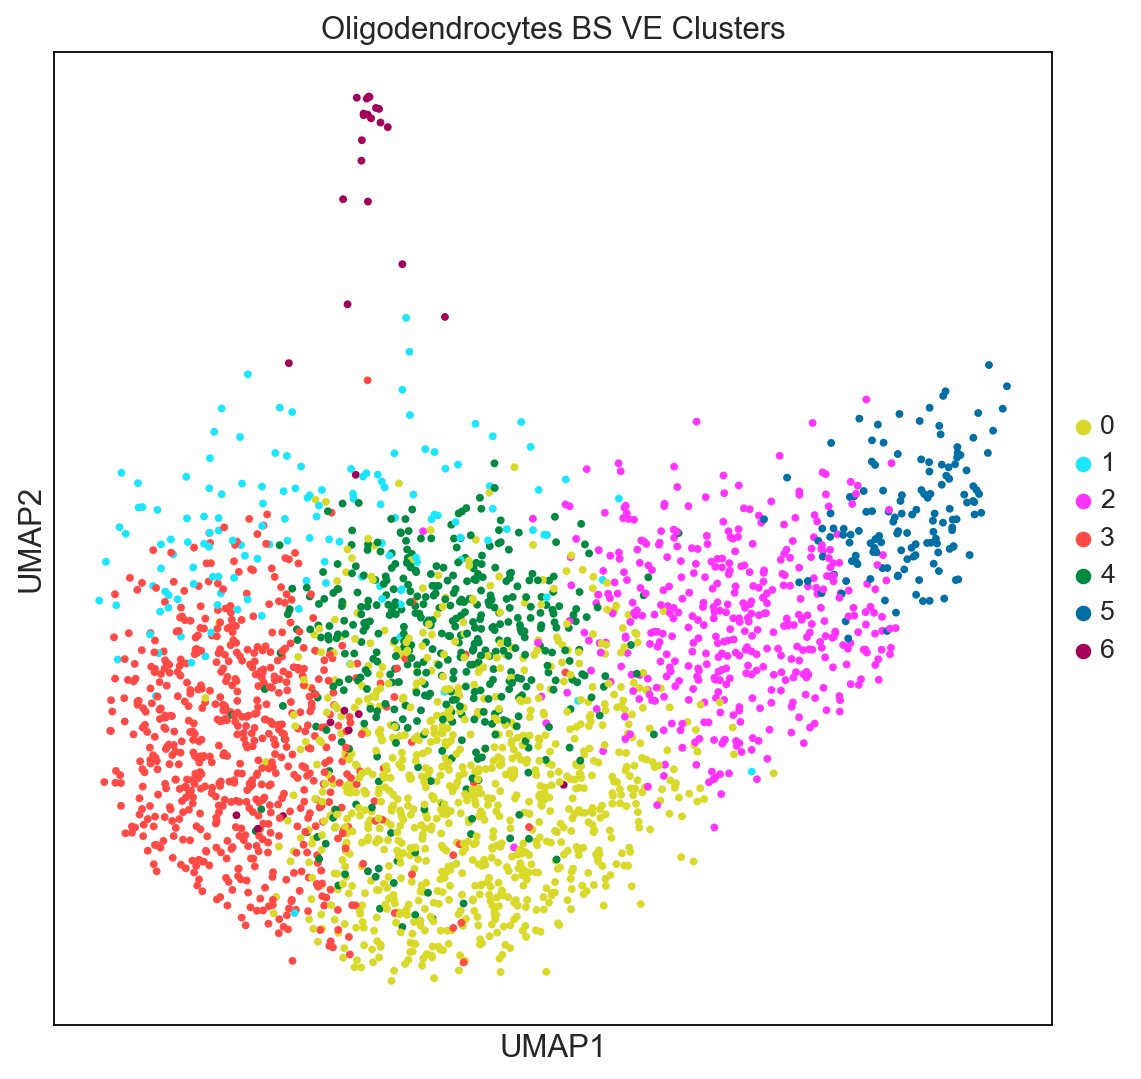

In [63]:
adata_oligo_BS_VE = adata_oligo_BS[adata_oligo_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_BS_VE, 
           color= ['PhenoGraph_clusters_oligo_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes BS VE Clusters"])

In [64]:
cell_counts_per_cluster_BS_VE = adata_oligo_BS_VE.obs.PhenoGraph_clusters_oligo_BS.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

PhenoGraph_clusters_oligo_BS
0                           927
3                           640
4                           440
2                           433
1                           142
5                           141
6                            29

# Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [65]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'),how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_oligo_BS_Control' : 'Control', 'PhenoGraph_clusters_oligo_BS_VE' : 'VE'}, inplace = True)
mergedDF

Control   VE
0       54  927
1      795  142
2      320  433
3       37  640
4       20  440
5      145  141
6        9   29

In [66]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

ClusterID Condition  N_cells
0          0   Control       54
1          1   Control      795
2          2   Control      320
3          3   Control       37
4          4   Control       20
5          5   Control      145
6          6   Control        9
7          0        VE      927
8          1        VE      142
9          2        VE      433
10         3        VE      640
11         4        VE      440
12         5        VE      141
13         6        VE       29

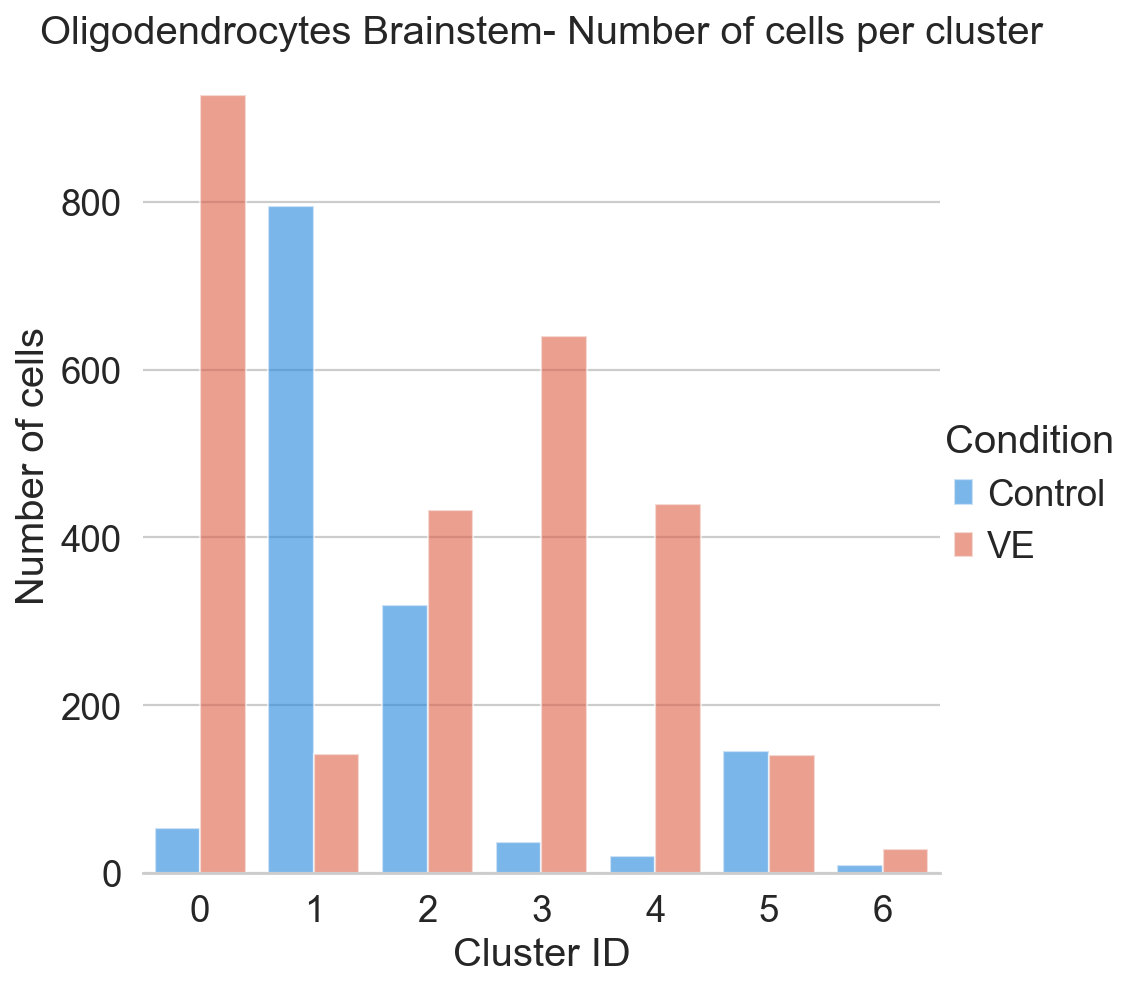

In [67]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Oligodendrocytes Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

# Compare Clusters 0+1+3+4+6 (VE) Versus All Controls

## T-test 

In [96]:
adata_oligo_BS_copy = adata_oligo_BS.copy()
# For loop creating a groups for pairwise comparison
adata_oligo_BS_copy.obs['groups'] = ['group_0_1_3_4_6VE' if int(i) in [0,1,3,4,6] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_oligo_BS_copy.obs['PhenoGraph_clusters_oligo_BS'],adata_oligo_BS_copy.obs['Condition'] )]


In [97]:
adata_oligo_BS_copy.obs.groups.value_counts()

group_0_1_3_4_6VE    2178
group_restCTRL       1380
Error                 574
Name: groups, dtype: int64

In [52]:
#adata_oligo_BS_copy.obs[['groups','PhenoGraph_clusters_astro','PhenoGraph_clusters_astro_str','Condition']]

In [98]:
# select only cells that are in these 2 groups that I want to compare
adata_oligo_BS_to_compare = adata_oligo_BS_copy[[group in ['group_restCTRL', 'group_0_1_3_4_6VE'] for group in adata_oligo_BS_copy.obs['groups']],].copy()
adata_oligo_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


group_0_1_3_4_6VE    2178
group_restCTRL       1380
Name: groups, dtype: int64

... storing 'groups' as categorical


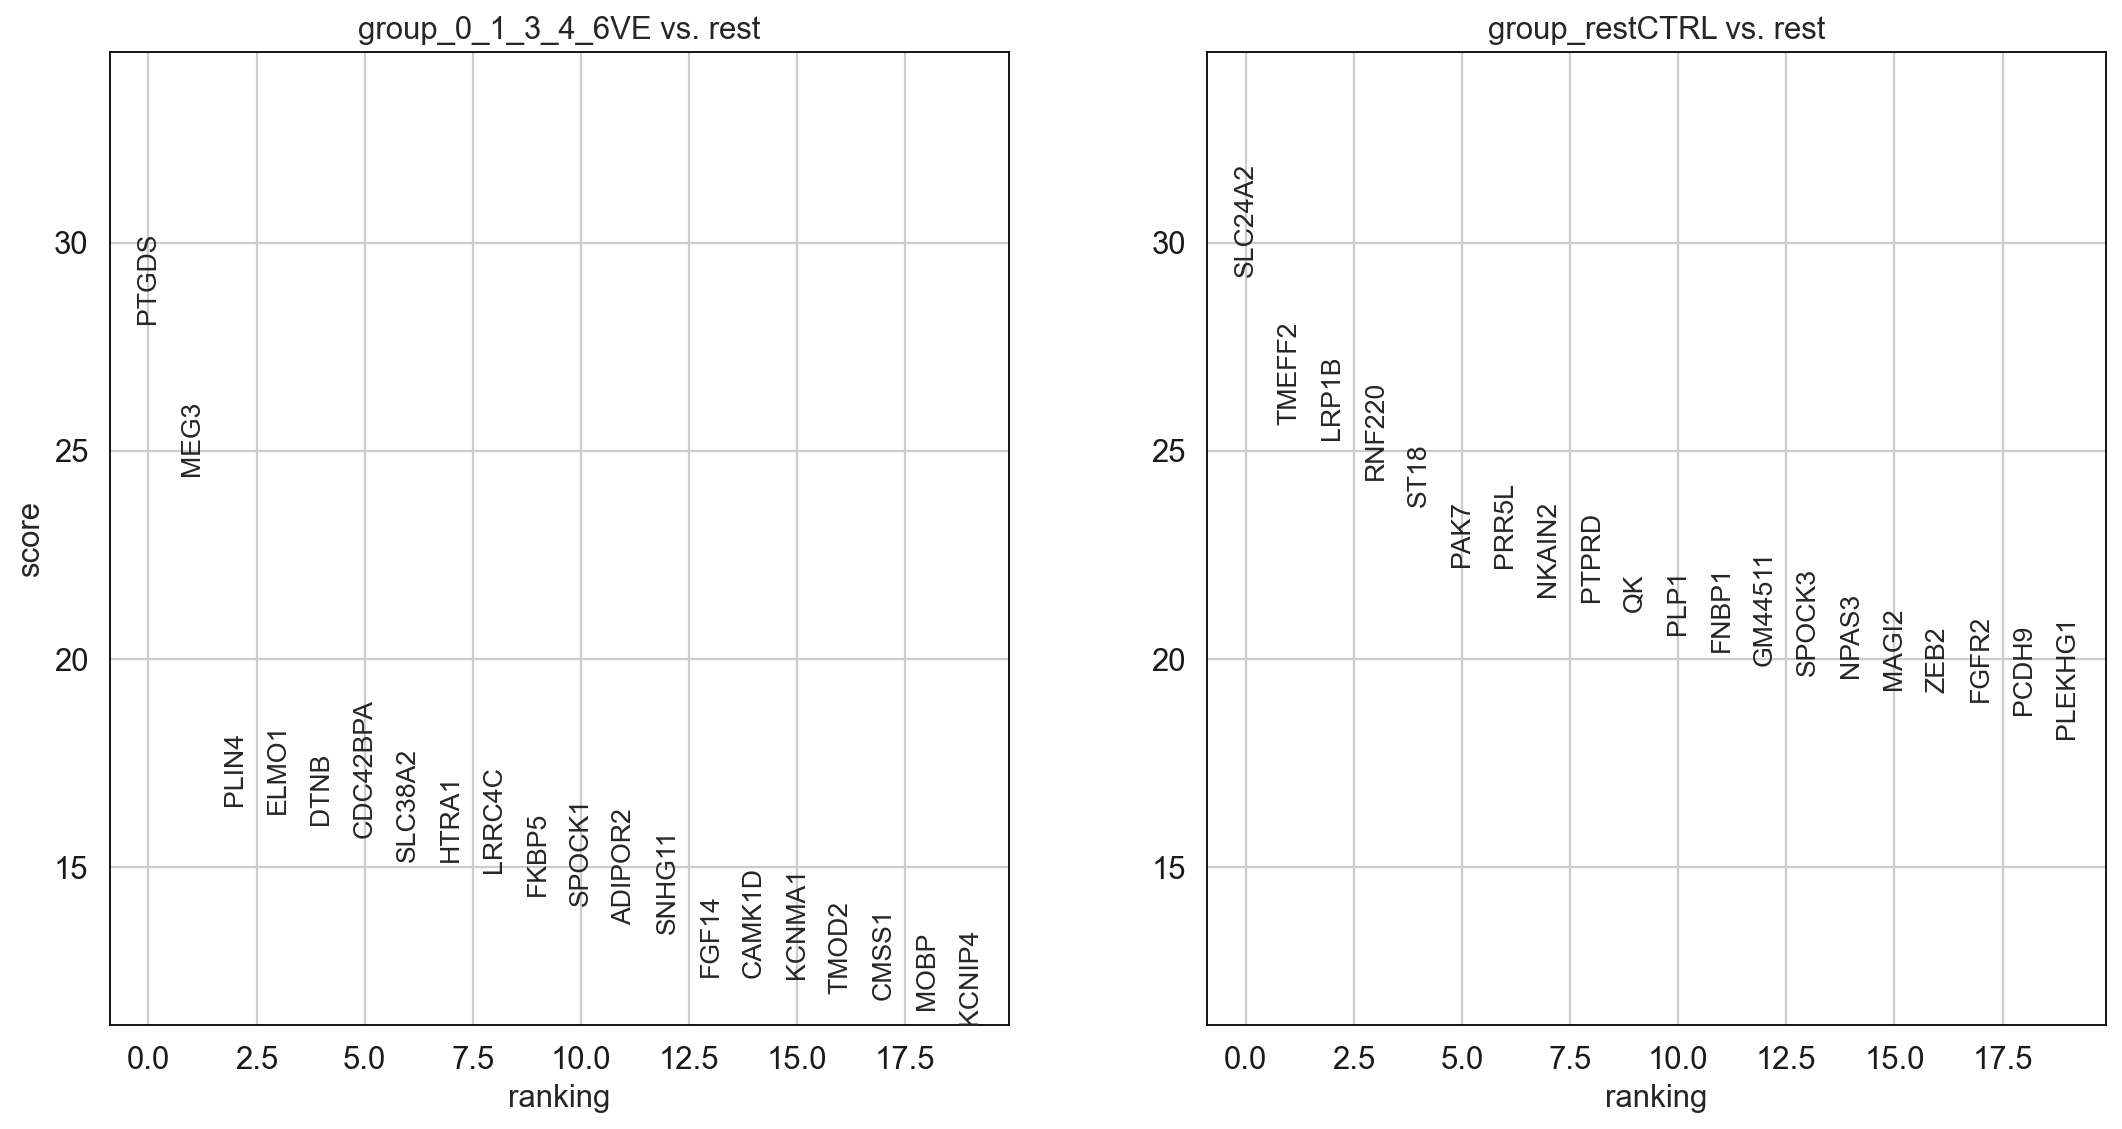

In [99]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_0_1_3_4_6VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_oligo_BS_to_compare, groupby='groups', key_added="group_0_1_3_4_6VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_oligo_BS_to_compare, key = 'group_0_1_3_4_6VE', fontsize=12)

result = adata_oligo_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [100]:
pval_table = pval_table.sort_values(by= 'group_0_1_3_4_6VE_l', ascending=False)
pval_table[(pval_table.group_0_1_3_4_6VE_p < 0.05) & (pval_table.group_0_1_3_4_6VE_l > 0.5)].head(10)

group_0_1_3_4_6VE_n  group_0_1_3_4_6VE_l  group_0_1_3_4_6VE_p  \
2                 PLIN4             4.235045         2.631244e-58   
0                 PTGDS             4.002672        3.511937e-169   
31                  C4B             3.320282         4.696564e-15   
9                 FKBP5             3.075360         5.157235e-44   
127              CDKN1A             3.010852         2.306807e-02   
77                ITIH5             2.991437         6.203532e-05   
24                HIF3A             2.865538         6.290356e-23   
30                 GLI2             2.430269         1.906896e-15   
4                  DTNB             2.267511         4.661278e-55   
15               KCNMA1             2.101872         1.323702e-32   

    group_restCTRL_n  group_restCTRL_l  group_restCTRL_p  
2              LRP1B          1.149950     2.303834e-137  
0            SLC24A2          1.354392     4.558876e-183  
31             EPHB1          1.940243      2.360543e-50  
9                 QK          1.320779      3.901764e-96  
127            PARK2          1.333697      7.991374e-20  
77             MDGA2          0.997325      7.225112e-27  
24              CAR2          2.013522      6.375510e-54  
30             SHTN1          2.067653      2.686638e-51  
4               ST18          1.719544     2.361644e-120  
15             MAGI2          0.694222      6.815854e-80

## MAST 

In [102]:
cell_type = 'Oligodendrocytes_Brainstem_C0_1_3_4_6'
expmat = pd.DataFrame(adata_oligo_BS_to_compare.X, columns = adata_oligo_BS_to_compare.var.index, index = adata_oligo_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_oligo_BS_to_compare.obs, columns=adata_oligo_BS_to_compare.obs.columns, index = adata_oligo_BS_to_compare.obs.index)
expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [103]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [104]:
# import the MAST results
mast_C0_1_3_4_6_res = pd.read_csv (filepath_or_buffer= '../DEA/Oligodendrocytes_Brainstem_C0_1_3_4_6/MAST_DEA_Oligodendrocytes_Brainstem_C0_1_3_4_6_RESULTS.csv')
print(mast_C0_1_3_4_6_res)

                 gene              p      p.fdr.adj     logFC
0               PLIN4  3.576941e-110  4.716555e-106  1.307575
1              TMEFF2  7.732048e-106  5.097739e-102 -0.877713
2               FKBP5  3.504847e-105  1.540497e-101  1.367785
3             SLC24A2  2.816181e-101   9.283542e-98 -0.723400
4                PLP1   1.964327e-93   5.180323e-90 -0.533034
...               ...            ...            ...       ...
13181           PLIN2   9.995131e-01   9.997673e-01 -0.000522
13182           VTCN1   9.995398e-01   9.997673e-01 -0.000425
13183         SNRNP25   9.997444e-01   9.998961e-01 -0.000508
13184         DENND1C   1.000000e+00   1.000000e+00 -0.000101
13185  X1700016D06RIK   1.000000e+00   1.000000e+00  0.000657

[13186 rows x 4 columns]


In [106]:
#filter DE results
mast_C0_1_3_4_6_res = mast_C0_1_3_4_6_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_C0_1_3_4_6_res_UP = mast_C0_1_3_4_6_res[(mast_C0_1_3_4_6_res['logFC'] >=0.01) & (mast_C0_1_3_4_6_res['p.fdr.adj'] <= 0.05)]
mast_C0_1_3_4_6_res_res_DOWN = mast_C0_1_3_4_6_res[(mast_C0_1_3_4_6_res['logFC'] <=0.01) & (mast_C0_1_3_4_6_res['p.fdr.adj'] <= 0.05)]
mast_C0_1_3_4_6_res_UP['gene'].shape

(2503,)

## HEATMAP OF TOP10 UPREGULATED GENES

In [107]:
marker_genes_dict = dict()

marker_genes_dict = {'C0_1_3_4_6_UP': mast_C0_1_3_4_6_res_UP['gene'].head(20)}

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


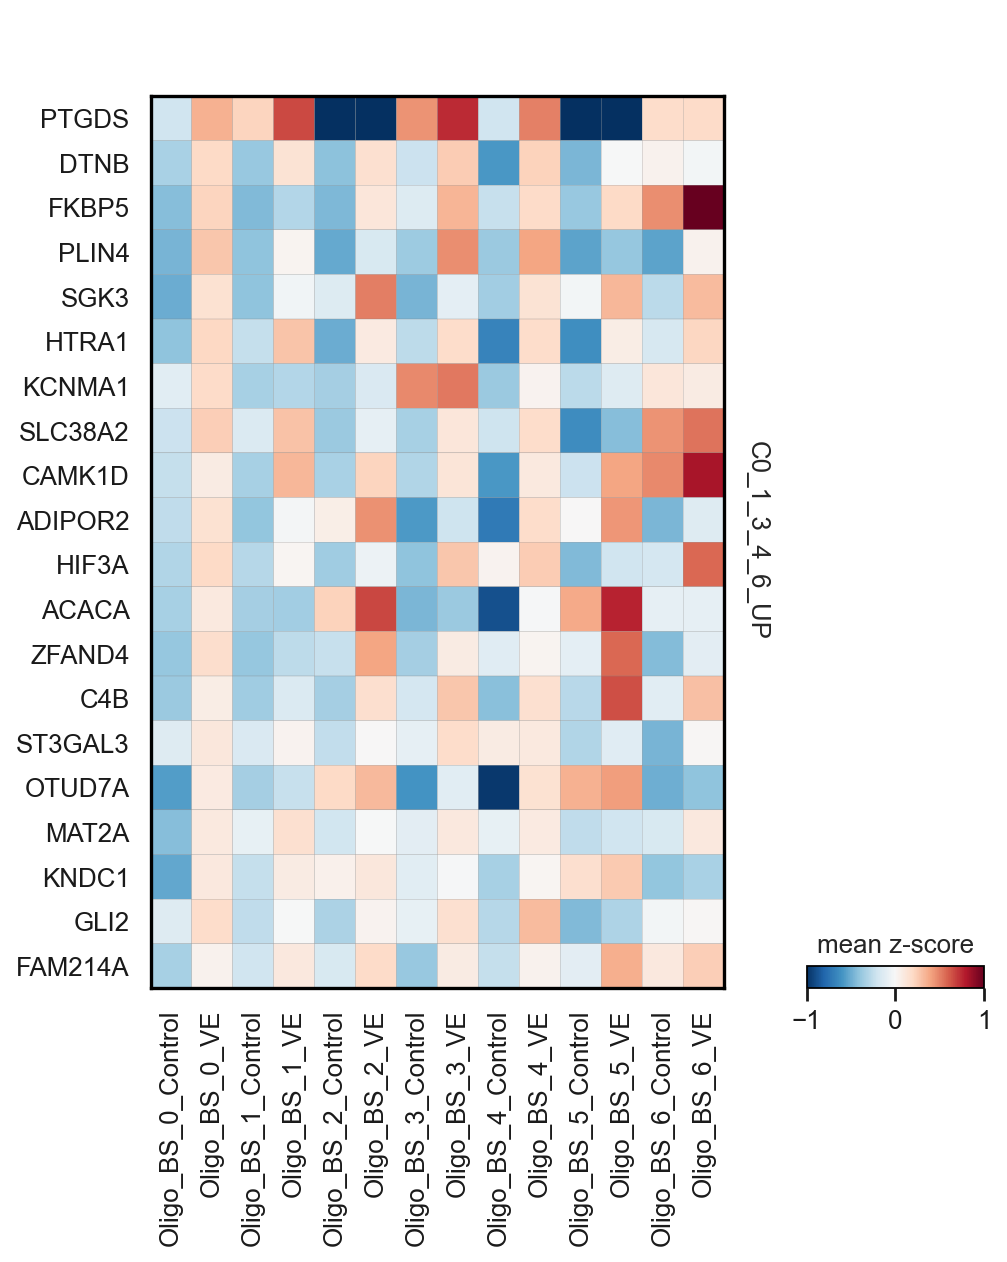

categories: Oligo_BS_0_Control, Oligo_BS_0_VE, Oligo_BS_1_Control, etc.
var_group_labels: C0_1_3_4_6_UP


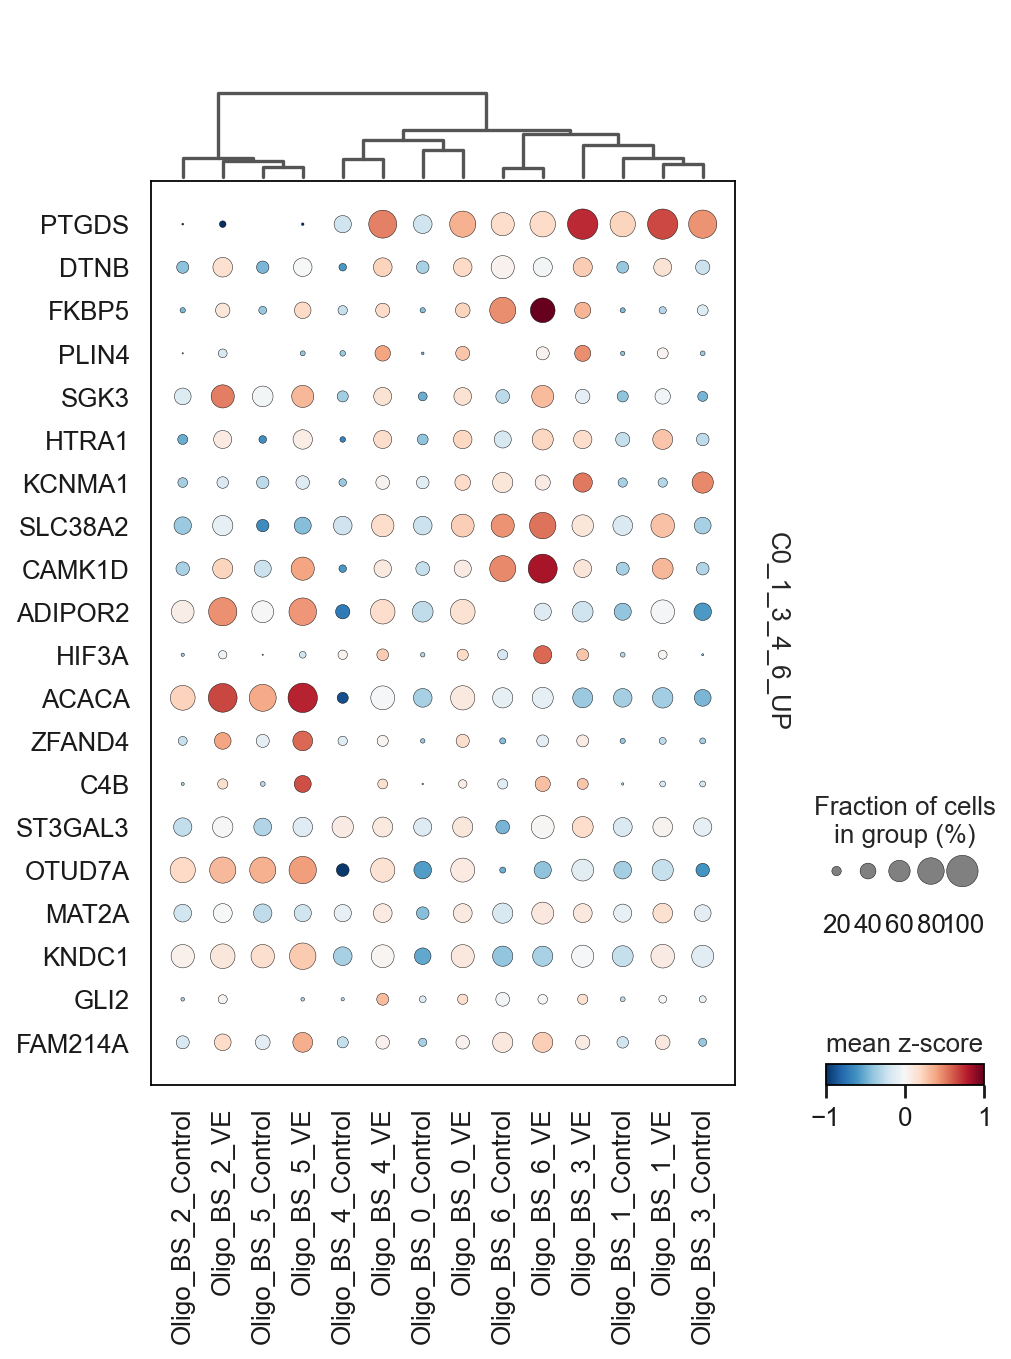

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


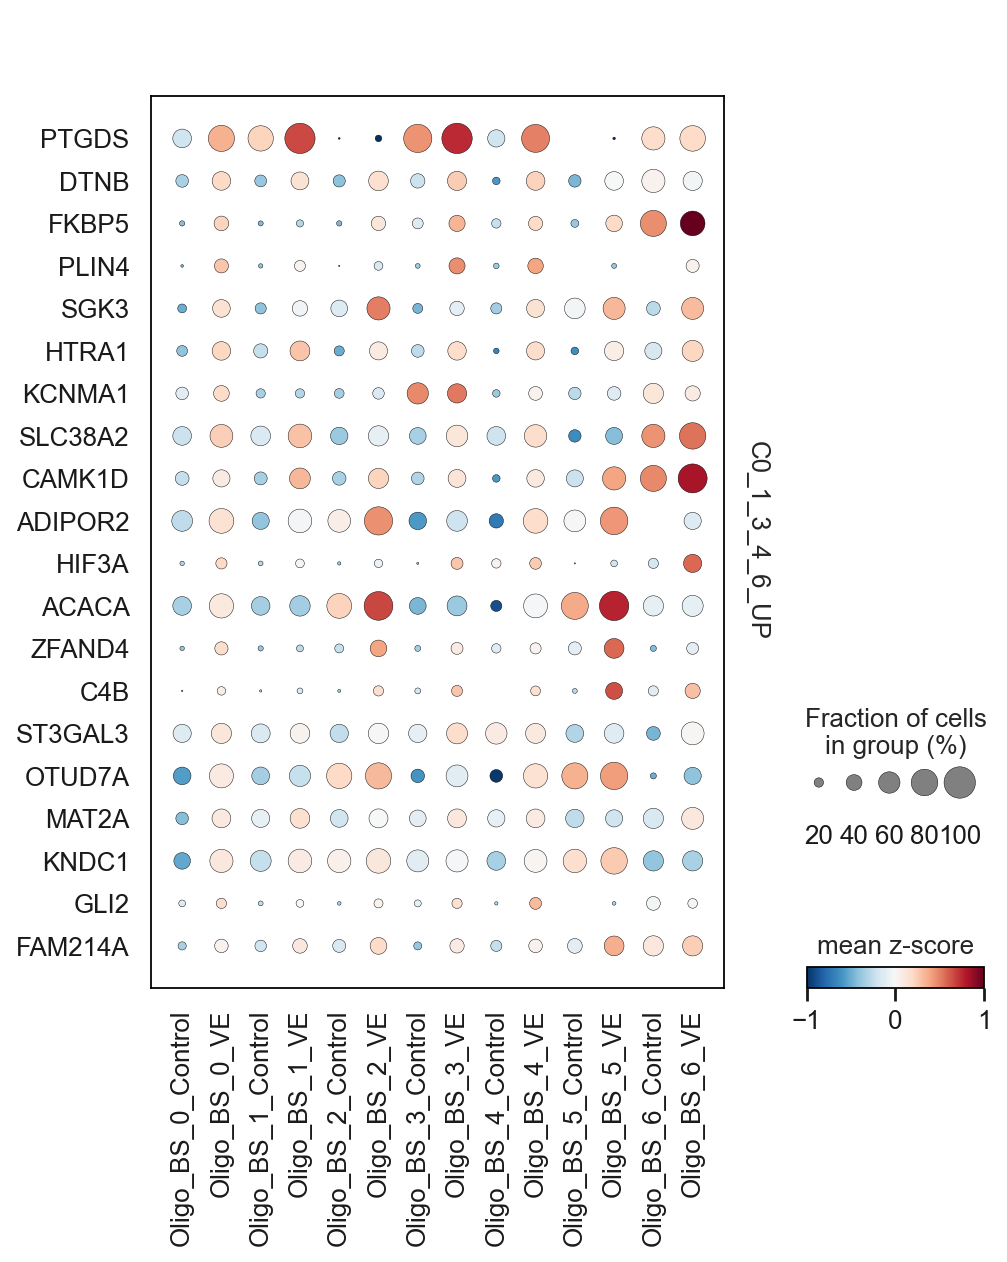

In [108]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X
sc.pl.matrixplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

## Enricher

In [162]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_mast_C0_1_3_4_6_res_n_list = mast_C0_1_3_4_6_res_UP.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_mast_C0_1_3_4_6_res_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [163]:
enr_res.results.head(20)

Gene_set                                         Term Overlap  \
0   KEGG_2019_Mouse  Protein processing in endoplasmic reticulum  57/163   
1   KEGG_2019_Mouse               Ubiquitin mediated proteolysis  48/138   
2   KEGG_2019_Mouse                       FoxO signaling pathway  46/132   
3   KEGG_2019_Mouse                                    Autophagy  43/130   
4   KEGG_2019_Mouse                            Colorectal cancer   30/88   
5   KEGG_2019_Mouse                            Pancreatic cancer   27/75   
6   KEGG_2019_Mouse                     Chronic myeloid leukemia   27/76   
7   KEGG_2019_Mouse                                    Mitophagy   24/63   
8   KEGG_2019_Mouse               Neurotrophin signaling pathway  36/121   
9   KEGG_2019_Mouse                    mRNA surveillance pathway   30/96   
10  KEGG_2019_Mouse                                  Hepatitis B  43/163   
11  KEGG_2019_Mouse                Inositol phosphate metabolism   25/73   
12  KEGG_2019_Mouse                 Longevity regulating pathway  31/102   
13  KEGG_2019_Mouse                       Long-term potentiation   23/67   
14  KEGG_2019_Mouse                              Prostate cancer   29/97   
15  KEGG_2019_Mouse        Phosphatidylinositol signaling system   29/98   
16  KEGG_2019_Mouse                 Choline metabolism in cancer   29/99   
17  KEGG_2019_Mouse                                  Spliceosome  35/132   
18  KEGG_2019_Mouse                   Oxytocin signaling pathway  39/154   
19  KEGG_2019_Mouse                       MAPK signaling pathway  63/294   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   1.074014e-13      3.093160e-11            0                     0   
1   1.154747e-11      1.662835e-09            0                     0   
2   2.859716e-11      2.745327e-09            0                     0   
3   8.231002e-10      5.926321e-08            0                     0   
4   1.337246e-07      7.555633e-06            0                     0   
5   1.574090e-07      7.555633e-06            0                     0   
6   2.151986e-07      8.083535e-06            0                     0   
7   2.245426e-07      8.083535e-06            0                     0   
8   3.858809e-07      1.234819e-05            0                     0   
9   1.122306e-06      3.120742e-05            0                     0   
10  1.191950e-06      3.120742e-05            0                     0   
11  1.319196e-06      3.166070e-05            0                     0   
12  1.463837e-06      3.242963e-05            0                     0   
13  3.305996e-06      6.800907e-05            0                     0   
14  4.543878e-06      8.724245e-05            0                     0   
15  5.689219e-06      1.024059e-04            0                     0   
16  7.093374e-06      1.201701e-04            0                     0   
17  1.002109e-05      1.593347e-04            0                     0   
18  1.051166e-05      1.593347e-04            0                     0   
19  1.138435e-05      1.639346e-04            0                     0   

    Odds Ratio  Combined Score  \
0     3.823289      114.171824   
1     3.781561       95.236942   
2     3.790338       92.020741   
3     3.497944       73.169796   
4     3.647462       57.730136   
5     3.964080       62.095009   
6     3.882958       59.610025   
7     4.333757       66.346360   
8     2.989256       44.144544   
9     3.203875       43.893483   
10    2.531203       34.525400   
11    3.667482       49.652164   
12    3.077886       41.349709   
13    3.678693       46.424272   
14    3.004428       36.959666   
15    2.960716       35.756383   
16    2.918253       34.599824   
17    2.543902       29.282396   
18    2.392356       27.423637   
19    1.929881       21.968356   

                                                Genes  
0   TRAM1;HSP90AB1;UBE2D3;NGLY1;ERO1L;HERPUD1;MAN1...  
1   UBE3C;CUL5;UBA6;MGRN1;CUL3;UBE2D3;CUL1;XIAP;CB...

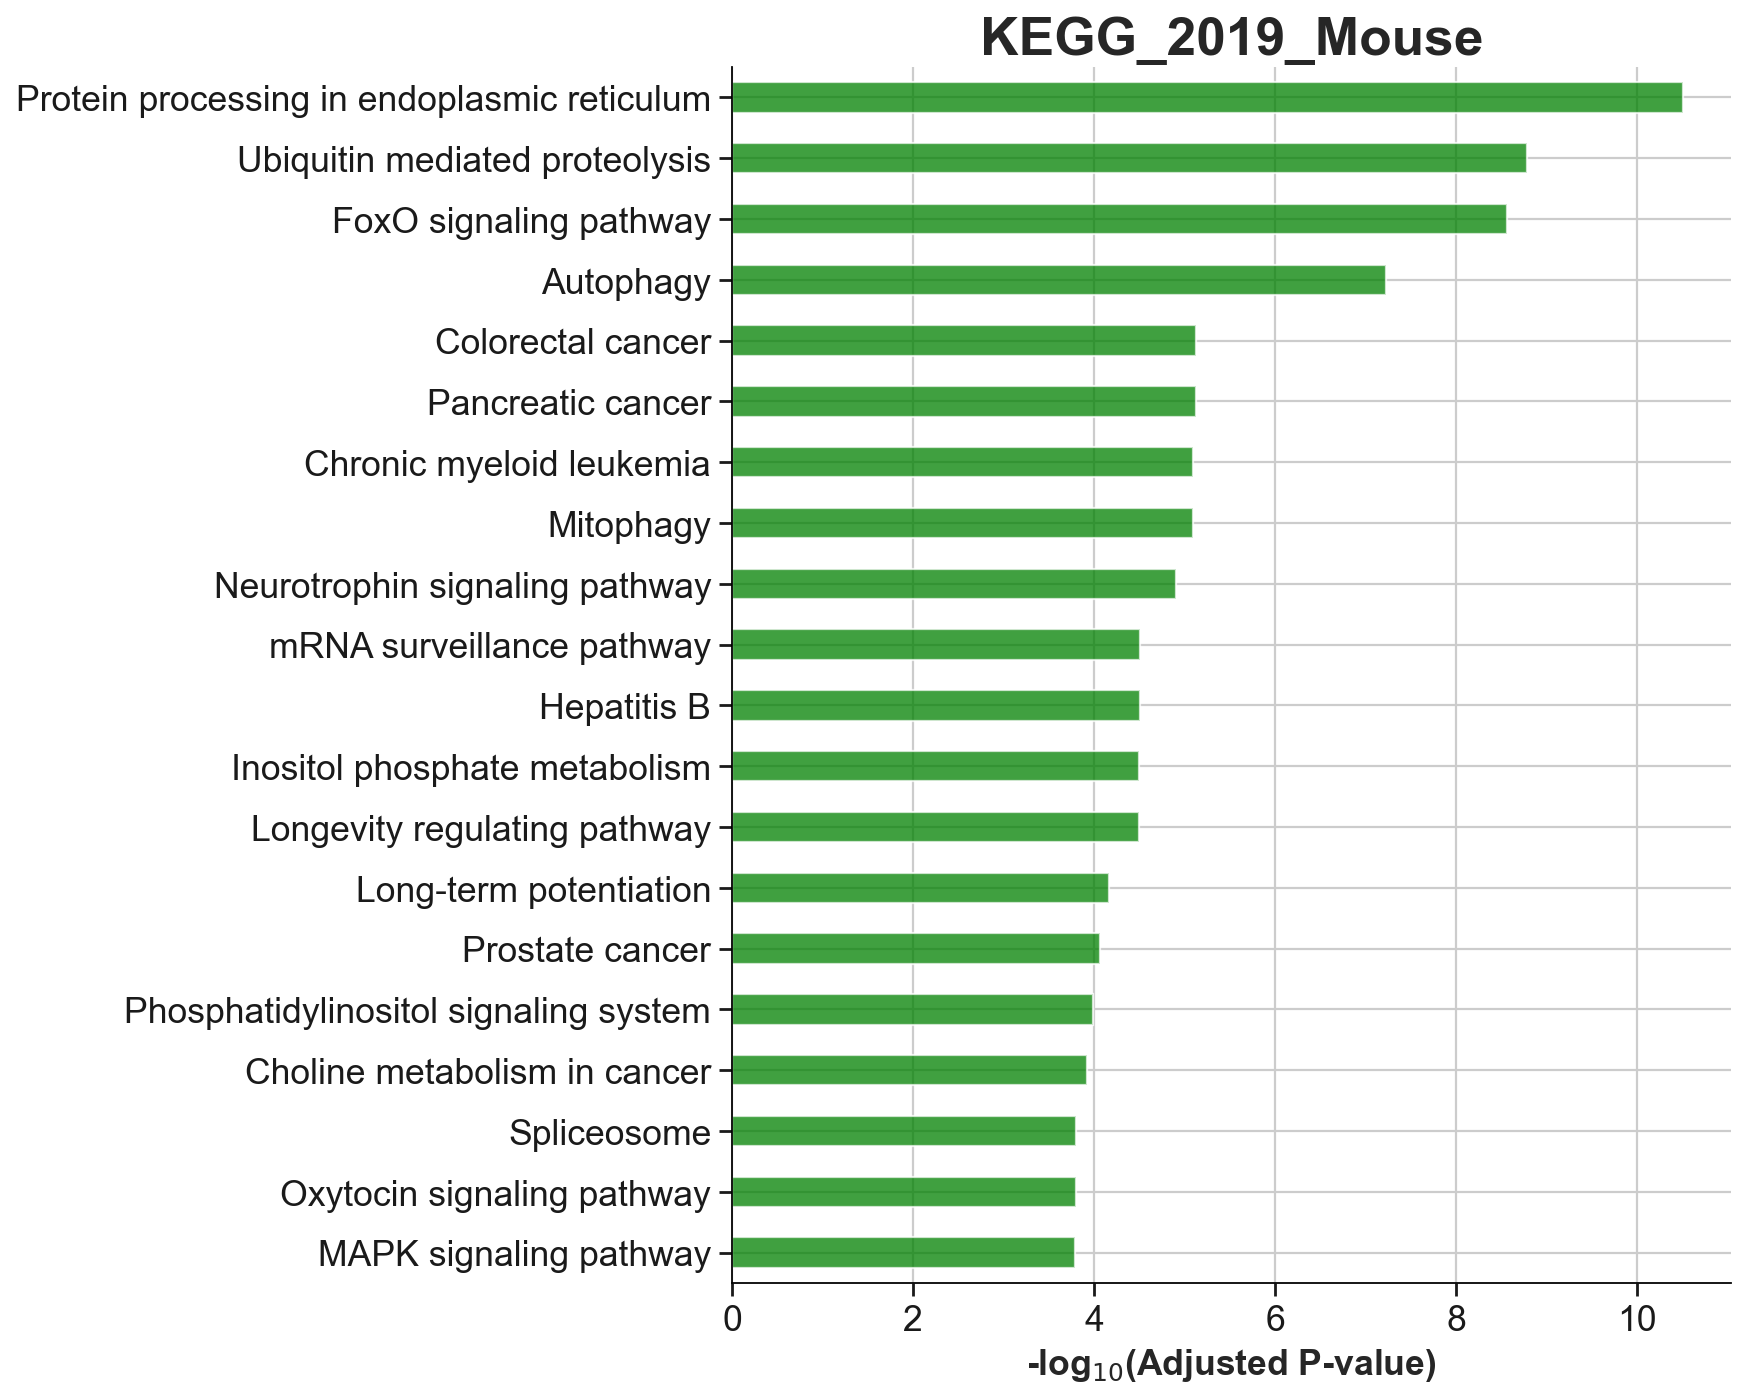

In [164]:
gseapy.barplot(enr_res.res2d,title='KEGG_2019_Mouse',top_term=20,color='green',figsize=(8,10))

In [ ]:
gseapy.dotplot(enr_res.res2d, title='WikiPathways_2019_Mouse',cmap='viridis_r', top_term=20, figsize=(6,8))

## GSEA pre-rank

In [122]:
mast_C0_1_3_4_6_res = mast_C0_1_3_4_6_res.dropna()
pval_table_rnk = mast_C0_1_3_4_6_res[['gene','logFC','p.fdr.adj']]

rank_score = pval_table_rnk['logFC'] * -np.log10(pval_table_rnk['p.fdr.adj'])
rank_score
pval_table_rnk['score'] = rank_score

In [ ]:
pval_table_rnk = pval_table_rnk.sort_values(by= 'score', ascending=False)
pval_table_rnk = pval_table_rnk[['gene', 'score']]
pval_table_rnk.head(15)

In [126]:
pre_res = gseapy.prerank(rnk=pval_table_rnk, 
                     gene_sets='MSigDB_Hallmark_2020',
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='../test/prerank_report_kegg', format='png', seed=6, graph_num=5)

In [ ]:
pre_res.res2d.sort_index().head(n=25).sort_values('fdr')

In [ ]:
Allen_Brain_Atlas_10x_scRNA_2021
MSigDB_Hallmark_2020
KEGG_2019_Mouse
MSigDB_Oncogenic_Signatures
Reactome_2016
WikiPathways_2019_Mouse
GO_Biological_Process_2018

In [160]:
#print(gene_set_names)

# Compare Clusters 2 + 5 (VE) Versus All Controls

## T-test 

In [128]:
adata_oligo_BS_copy = adata_oligo_BS.copy()
# For loop creating a groups for pairwise comparison
adata_oligo_BS_copy.obs['groups'] = ['group_2_5VE' if int(i) in [2,5] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_oligo_BS_copy.obs['PhenoGraph_clusters_oligo_BS'],adata_oligo_BS_copy.obs['Condition'] )]


In [129]:
adata_oligo_BS_copy.obs.groups.value_counts()

Error             2178
group_restCTRL    1380
group_2_5VE        574
Name: groups, dtype: int64

In [52]:
#adata_oligo_BS_copy.obs[['groups','PhenoGraph_clusters_astro','PhenoGraph_clusters_astro_str','Condition']]

In [130]:
# select only cells that are in these 2 groups that I want to compare
adata_oligo_BS_to_compare = adata_oligo_BS_copy[[group in ['group_restCTRL', 'group_2_5VE'] for group in adata_oligo_BS_copy.obs['groups']],].copy()
adata_oligo_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


group_restCTRL    1380
group_2_5VE        574
Name: groups, dtype: int64

... storing 'groups' as categorical


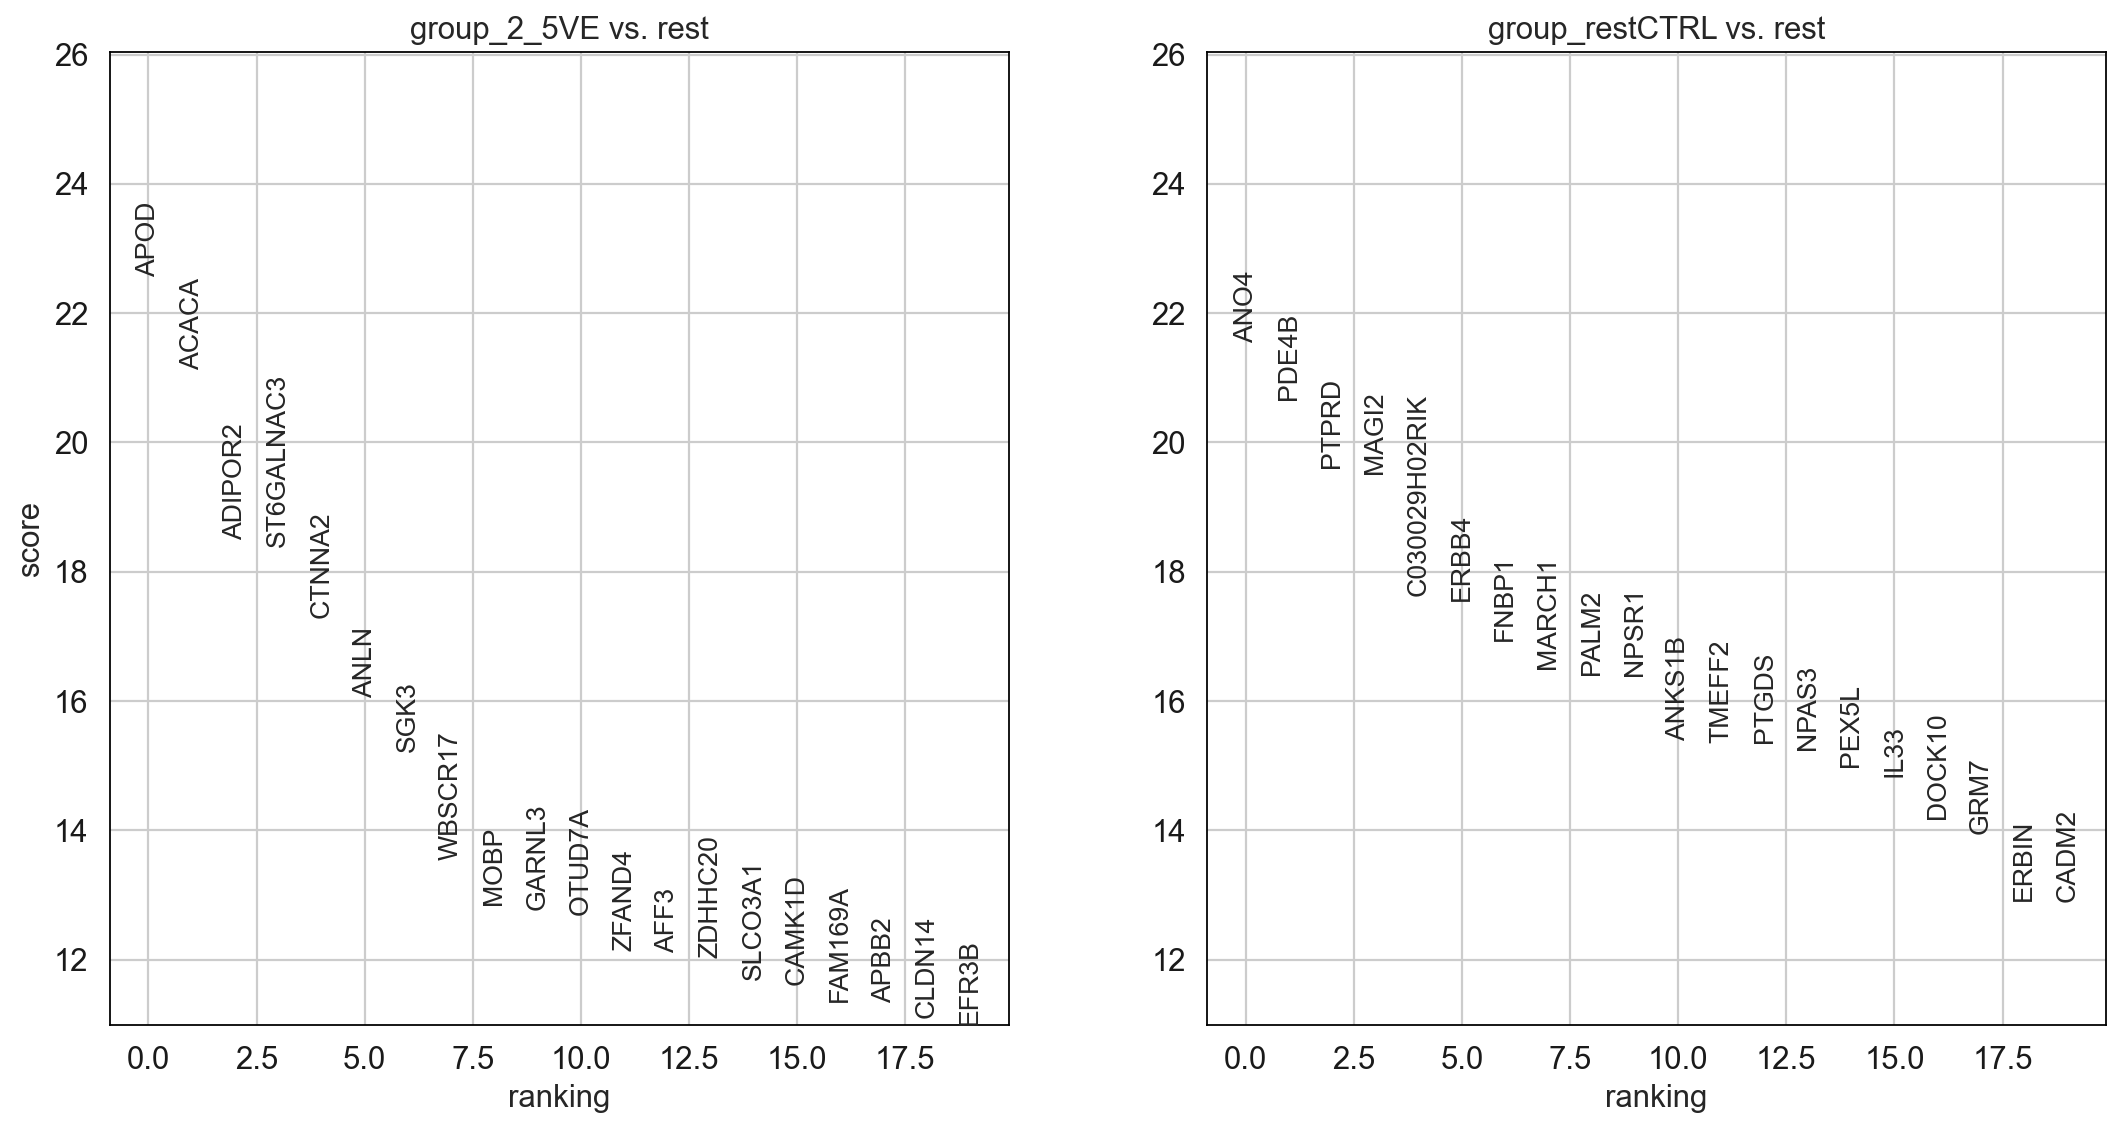

In [131]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_2_5VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_oligo_BS_to_compare, groupby='groups', key_added="group_2_5VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_oligo_BS_to_compare, key = 'group_2_5VE', fontsize=12)

result = adata_oligo_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [133]:
pval_table = pval_table.sort_values(by= 'group_2_5VE_l', ascending=False)
pval_table[(pval_table.group_2_5VE_p < 0.05) & (pval_table.group_2_5VE_l > 0.5)].head(10)

group_2_5VE_n  group_2_5VE_l  group_2_5VE_p group_restCTRL_n  \
43            C4B       3.858826   4.475200e-15            PACRG   
7         WBSCR17       3.305732   4.162719e-39           MARCH1   
16        FAM169A       3.210891   1.976642e-27           DOCK10   
193         ITIH5       3.122178   2.442101e-03          GM26694   
31           ART3       3.108725   7.621913e-21             ST18   
11         ZFAND4       3.015689   2.379821e-31           TMEFF2   
166         SCRG1       2.783830   4.647001e-04           DNAJC6   
32          FKBP5       2.781743   5.186175e-20           PCDH15   
6            SGK3       2.712264   1.853057e-49            FNBP1   
1           ACACA       2.671530   2.038585e-95            PDE4B   

     group_restCTRL_l  group_restCTRL_p  
43           1.967147      7.844681e-24  
7            2.427228      3.751178e-58  
16           1.081807      7.459326e-43  
193          1.097561      6.971749e-05  
31           0.879658      3.337732e-27  
11           1.111367      2.342335e-50  
166          1.110856      2.362936e-06  
32           2.129147      3.712718e-27  
6            1.574982      3.183828e-61  
1            1.138393      2.317755e-91

## MAST 

In [134]:
cell_type = 'Oligodendrocytes_Brainstem_C2_5'
expmat = pd.DataFrame(adata_oligo_BS_to_compare.X, columns = adata_oligo_BS_to_compare.var.index, index = adata_oligo_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_oligo_BS_to_compare.obs, columns=adata_oligo_BS_to_compare.obs.columns, index = adata_oligo_BS_to_compare.obs.index)
expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [137]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [138]:
# import the MAST results
mast_C2_5_res = pd.read_csv (filepath_or_buffer= '../DEA/Oligodendrocytes_Brainstem_C2_5/MAST_DEA_Oligodendrocytes_Brainstem_C2_5_RESULTS.csv')
print(mast_C2_5_res)

                 gene              p      p.fdr.adj     logFC
0                APOD  1.030091e-135  1.358278e-131  1.599984
1               ACACA  5.051976e-128  3.330768e-124  1.789767
2                ANO4  3.921208e-121  1.723502e-117 -2.312375
3               PDE4B  1.618949e-111  5.336866e-108 -0.819195
4       C030029H02RIK  2.443899e-103  6.445050e-100 -2.118075
...               ...            ...            ...       ...
13181           HBEGF   9.992373e-01   1.000000e+00 -0.000332
13182        MIR9.3HG   9.998362e-01   1.000000e+00  0.000139
13183             MOK   9.996908e-01   1.000000e+00 -0.000167
13184  X1700008O03RIK   9.995290e-01   1.000000e+00 -0.000504
13185  X1700110C19RIK   9.998138e-01   1.000000e+00  0.000065

[13186 rows x 4 columns]


In [140]:
#filter DE results
mast_C2_5_res = mast_C2_5_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_C2_5_res_UP = mast_C2_5_res[(mast_C2_5_res['logFC'] >=0.01) & (mast_C2_5_res['p.fdr.adj'] <= 0.05)]
mast_C2_5_res_DOWN = mast_C2_5_res[(mast_C2_5_res['logFC'] <=0.01) & (mast_C2_5_res['p.fdr.adj'] <= 0.05)]
mast_C2_5_res_DOWN['gene'].shape

(674,)

## HEATMAP OF TOP10 UPREGULATED GENES

In [146]:
marker_genes_dict = dict()

marker_genes_dict = {'C2_5': mast_C2_5_res['gene'].head(20)}

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


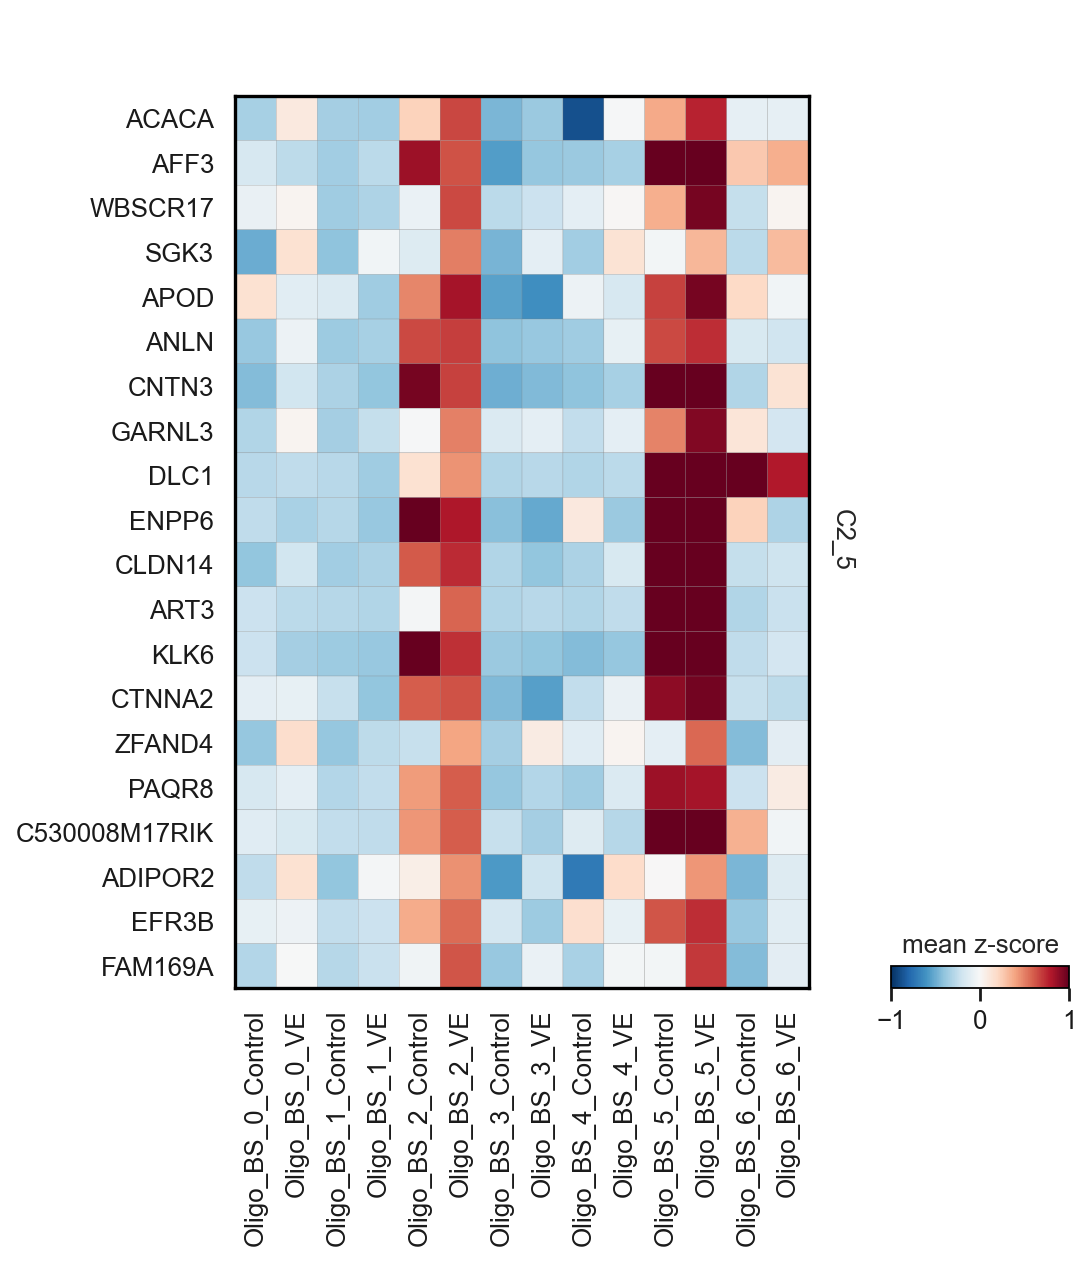

categories: Oligo_BS_0_Control, Oligo_BS_0_VE, Oligo_BS_1_Control, etc.
var_group_labels: C2_5


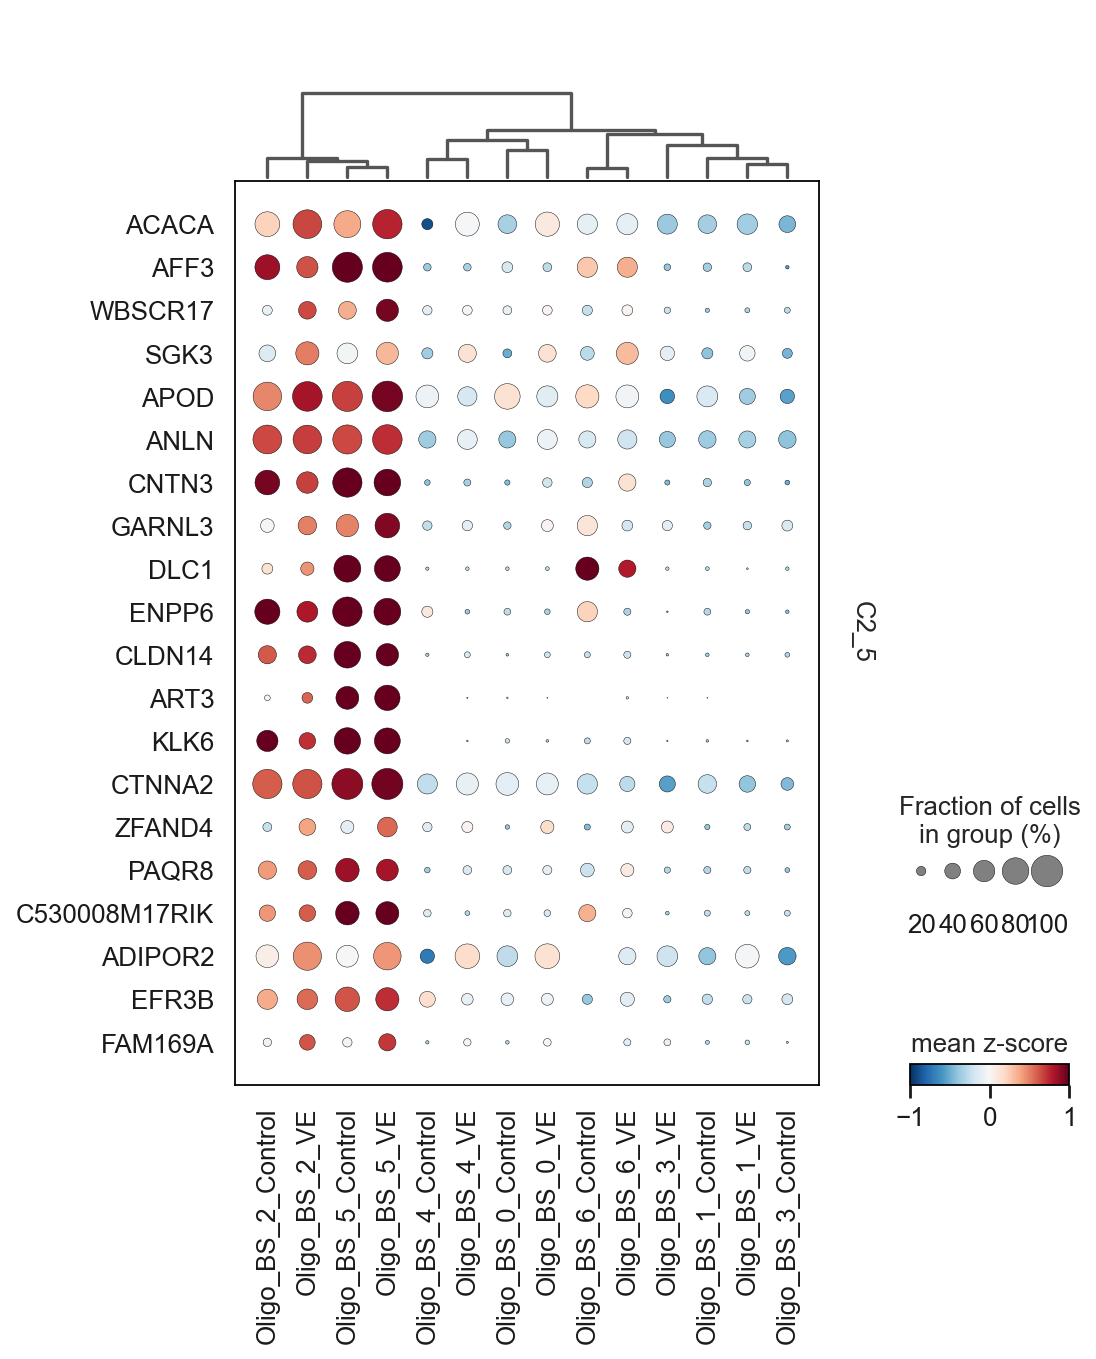

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


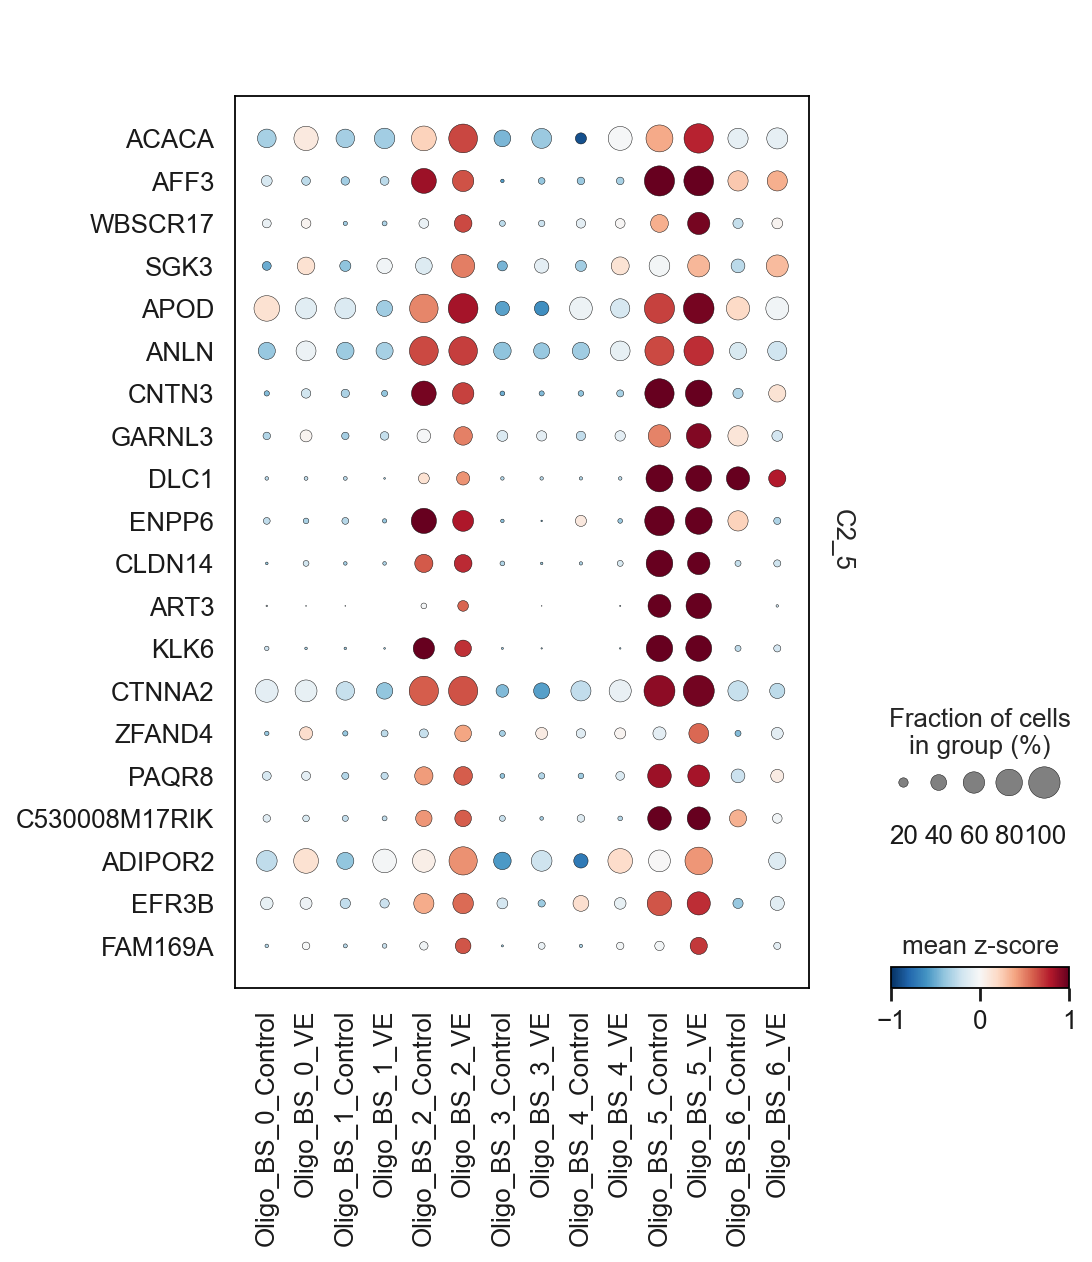

In [147]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X
sc.pl.matrixplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

## Enricher

In [156]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_C2_5_res_n_list = mast_C2_5_res_DOWN.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_C2_5_res_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [157]:
enr_res.results.head(20)

Gene_set                                               Term  \
0   KEGG_2019_Mouse                                      Axon guidance   
1   KEGG_2019_Mouse                                     Focal adhesion   
2   KEGG_2019_Mouse            Proximal tubule bicarbonate reclamation   
3   KEGG_2019_Mouse             Bacterial invasion of epithelial cells   
4   KEGG_2019_Mouse                             Rap1 signaling pathway   
5   KEGG_2019_Mouse  Arrhythmogenic right ventricular cardiomyopath...   
6   KEGG_2019_Mouse                            Hippo signaling pathway   
7   KEGG_2019_Mouse                         PI3K-Akt signaling pathway   
8   KEGG_2019_Mouse                              Glutamatergic synapse   
9   KEGG_2019_Mouse                  Thyroid hormone signaling pathway   
10  KEGG_2019_Mouse          Aldosterone-regulated sodium reabsorption   
11  KEGG_2019_Mouse                   Fc gamma R-mediated phagocytosis   
12  KEGG_2019_Mouse                                        Endocytosis   
13  KEGG_2019_Mouse                                     Bile secretion   
14  KEGG_2019_Mouse                                     Tight junction   
15  KEGG_2019_Mouse             Adrenergic signaling in cardiomyocytes   
16  KEGG_2019_Mouse                  Phospholipase D signaling pathway   
17  KEGG_2019_Mouse                             Gastric acid secretion   
18  KEGG_2019_Mouse              Carbohydrate digestion and absorption   
19  KEGG_2019_Mouse                         Cardiac muscle contraction   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   24/180  9.500974e-09          0.000002            0                     0   
1   17/199  4.289508e-04          0.051561            0                     0   
2     5/22  6.998324e-04          0.051561            0                     0   
3     9/74  8.316365e-04          0.051561            0                     0   
4   16/209  1.987220e-03          0.098566            0                     0   
5     8/72  2.859253e-03          0.102127            0                     0   
6   13/159  2.882611e-03          0.102127            0                     0   
7   22/357  5.007344e-03          0.136761            0                     0   
8   10/114  5.187002e-03          0.136761            0                     0   
9   10/115  5.514572e-03          0.136761            0                     0   
10    5/38  8.565099e-03          0.168590            0                     0   
11    8/87  9.013245e-03          0.168590            0                     0   
12  17/269  1.002815e-02          0.168590            0                     0   
13    7/72  1.060598e-02          0.168590            0                     0   
14  12/167  1.115761e-02          0.168590            0                     0   
15  11/148  1.167389e-02          0.168590            0                     0   
16  11/149  1.223458e-02          0.168590            0                     0   
17    7/74  1.223638e-02          0.168590            0                     0   
18    5/43  1.432194e-02          0.186939            0                     0   
19    7/78  1.602622e-02          0.198725            0                     0   

    Odds Ratio  Combined Score  \
0     4.537278       83.812018   
1     2.721729       21.104743   
2     8.488965       61.669528   
3     4.010388       28.442130   
4     2.410571       14.996204   
5     3.615240       21.175167   
6     2.583674       15.112058   
7     1.912838       10.132013   
8     2.783538       14.645862   
9     2.756885       14.336796   
10    4.369480       20.798983   
11    2.926521       13.781166   
12    1.958505        9.013746   
13    3.109837       14.138370   
14    2.242004       10.079226   
15    2.323865       10.342131   
16    2.306905       10.158431   
17    3.016693       13.283531   
18    3.793565       16.107335   
19    2.846147       11.764632   

                                       

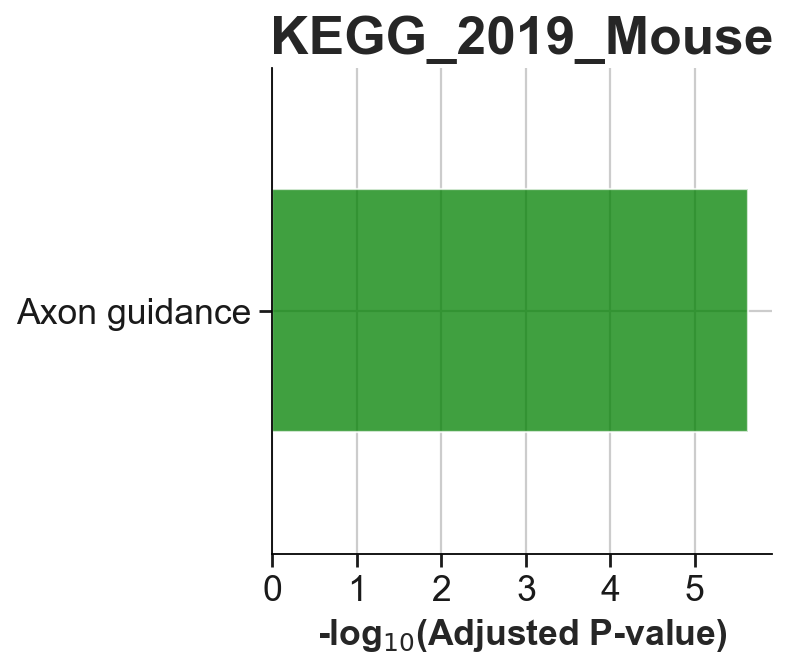

In [158]:
gseapy.barplot(enr_res.res2d,title='KEGG_2019_Mouse',top_term=20,color='green',figsize=(4,4))

In [ ]:
gseapy.dotplot(enr_res.res2d, title='WikiPathways_2019_Mouse',cmap='viridis_r', top_term=20, figsize=(6,8))